# Data Augmentation with Back-translation method on Imbalanced Text Dataset for Korean Vishing Classification

In [74]:
import torch

# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# If CUDA is available, print the current GPU details
if torch.cuda.is_available():
    print("Current GPU Index:", torch.cuda.current_device())
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    print("GPU Memory Allocated:", torch.cuda.memory_allocated())
    print("GPU Memory Cached:", torch.cuda.memory_reserved())

CUDA Available: True
Current GPU Index: 0
Current GPU Name: NVIDIA GeForce RTX 3050
GPU Memory Allocated: 0
GPU Memory Cached: 0


In [75]:
#importing necessary libraries
# General
from time import time
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import re
import os
import io
import pickle
import sys
import subprocess
from collections import Counter

# EDA
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter

# NLP 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize 

# ML
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score

# Data importation and Analysis

In [76]:
# import the train, validation and the test sets
print('Loading datasets...')
train_set= pd.read_csv('training_set.csv')
val_set = pd.read_csv('validation_set.csv')
test_set = pd.read_csv('test_set.csv')

# import all augmented dataset
train_set_ch = pd.read_csv('vishing_dataset_CH_AUG.csv')
train_set_en = pd.read_csv('vishing_dataset_EN_AUG.csv')
train_set_ja = pd.read_csv('vishing_dataset_JA_AUG.csv')

print('Datasets loaded.')

Loading datasets...
Datasets loaded.


In [77]:
# Delete all the rows in train_set_en, train_set_ja and train_set_ch that have label 0
train_set_ch = train_set_ch[train_set_ch['label'] != 0]
train_set_en = train_set_en[train_set_en['label'] != 0]
train_set_ja = train_set_ja[train_set_ja['label'] != 0]

In [78]:
def plot_class_distribution(data, title):
    sns.set(style="whitegrid")
    # sns.set(style="ticks")
    ax = sns.countplot(x='label', data=data)
    ax.set_title(title)
    
    # Annotate the bars with the number of samples
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        
    plt.show()

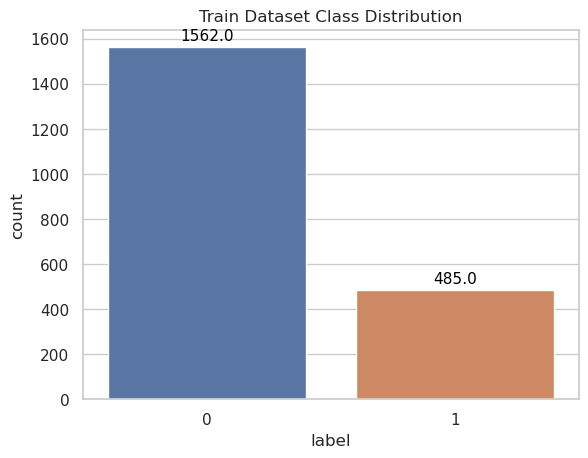

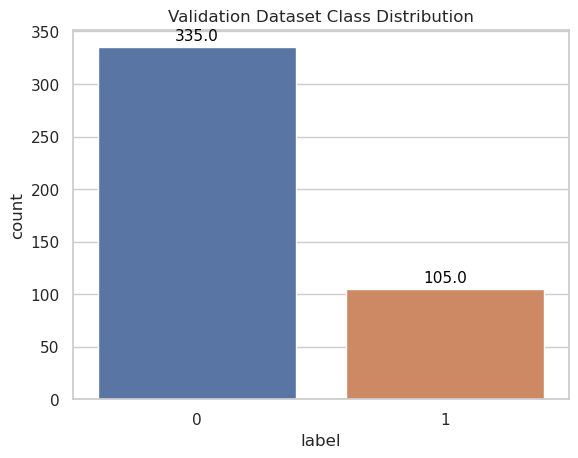

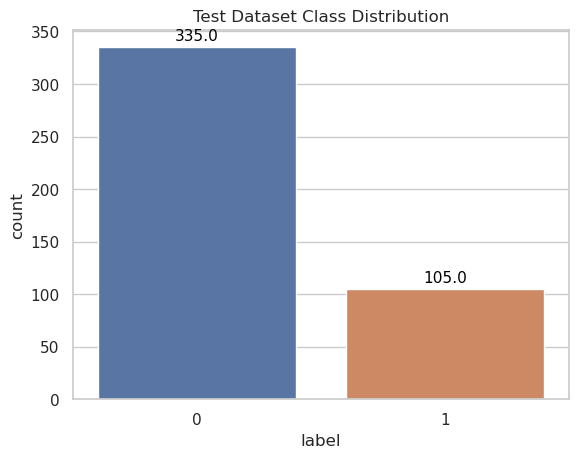

In [79]:
#plot the distribution of the datasets
plot_class_distribution(train_set, 'Train Dataset Class Distribution')
plot_class_distribution(val_set, 'Validation Dataset Class Distribution')
plot_class_distribution(test_set, 'Test Dataset Class Distribution')

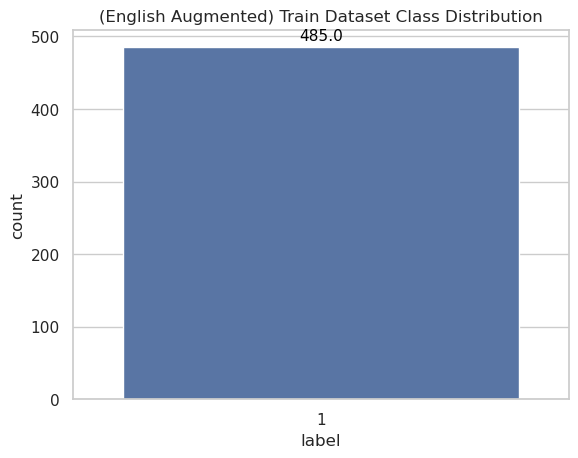

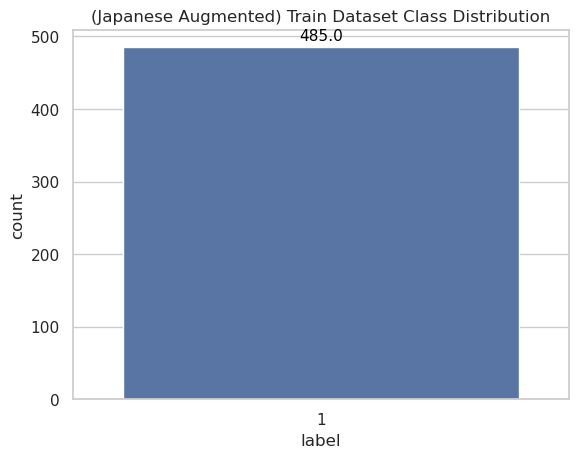

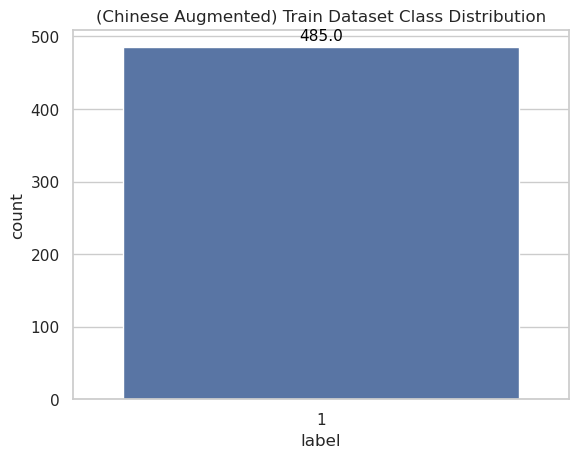

In [80]:
#plot the distribution of the datasets
plot_class_distribution(train_set_en, '(English Augmented) Train Dataset Class Distribution')
plot_class_distribution(train_set_ja, '(Japanese Augmented) Train Dataset Class Distribution')
plot_class_distribution(train_set_ch, '(Chinese Augmented) Train Dataset Class Distribution')

In [81]:
train_set.info()
val_set.info()
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 0 to 2046
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          2047 non-null   int64 
 1   transcript  2047 non-null   object
 2   label       2047 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 48.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          440 non-null    int64 
 1   transcript  440 non-null    object
 2   label       440 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 10.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          440 non-null    int64 
 1   transcript  440 non-null    object
 2   label       440 non

In [82]:
train_set_en.info()
train_set_ja.info()
train_set_ch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 3 to 2040
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                485 non-null    int64 
 1   transcript        480 non-null    object
 2   translation       485 non-null    object
 3   back_translation  485 non-null    object
 4   label             485 non-null    int64 
 5   processed         485 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 26.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 3 to 2040
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                485 non-null    int64 
 1   transcript        480 non-null    object
 2   translation       485 non-null    object
 3   back_translation  485 non-null    object
 4   label             485 non-null    int64 
 5   processed         485 non-null    int64 
dty

In [83]:
# drop the colum we don't need
train_set.drop(['id'], axis=1, inplace=True)
val_set.drop(['id'], axis=1, inplace=True)
test_set.drop(['id'], axis=1, inplace=True)

#check the dataframes
train_set.info()
val_set.info()
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 0 to 2046
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   transcript  2047 non-null   object
 1   label       2047 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   transcript  440 non-null    object
 1   label       440 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   transcript  440 non-null    object
 1   label       440 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ KB


In [84]:
# drop the colum we don't need
train_set_en.drop(['id', 'transcript', 'translation', 'processed'], axis=1, inplace=True)
train_set_ja.drop(['id', 'transcript', 'translation', 'processed'], axis=1, inplace=True)
train_set_ch.drop(['id', 'transcript', 'translation', 'processed'], axis=1, inplace=True)

#check the dataframes
train_set_en.info()
train_set_ja.info()
train_set_ch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 3 to 2040
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   back_translation  485 non-null    object
 1   label             485 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 3 to 2040
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   back_translation  485 non-null    object
 1   label             485 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 3 to 2040
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   back_translation  485 non-null    object
 1   label             485 non-null    int64 
dtypes: int64(1), object(1)
mem

In [85]:
# rename the column back_translation of train_set_en, train_set_ja, train_set_ch to transcript_en, transcript_ja, transcript_ch
train_set_en.rename(columns={'back_translation':'transcript_en'}, inplace=True)
train_set_ja.rename(columns={'back_translation':'transcript_ja'}, inplace=True)
train_set_ch.rename(columns={'back_translation':'transcript_ch'}, inplace=True)

# display the info of the dataframes
train_set_en.info()
train_set_ja.info()
train_set_ch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 3 to 2040
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transcript_en  485 non-null    object
 1   label          485 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 3 to 2040
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transcript_ja  485 non-null    object
 1   label          485 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 3 to 2040
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transcript_ch  485 non-null    object
 1   label          485 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB


 ## Calculating the length of each data sample.

In [86]:
# calculate the length of each data sample in the train_set, val_set and test_set and add the length as a new column named length to the dataframes
train_set['length'] = train_set['transcript'].apply(lambda x: len(x))
val_set['length'] = val_set['transcript'].apply(lambda x: len(x))
test_set['length'] = test_set['transcript'].apply(lambda x: len(x))

# display the heads of the dataframes
train_set.head()

,transcript,label,length
0,크리스마스 식탁 위에 빠지지 않고 등장하는 존재가 있어. 하얀 생크림 시트 위에 형...,0,3128
1,어~ 혹시 씨는 가족 관계가 어떻게 돼요? 저희 가족은 다섯 명으로 이루어져 있는...,0,6280
2,음~ 먹거리라는 주제를 가지고 얘기를 해 보고 싶어요. 선생님 요즘에 여름이라서 식...,0,5507
3,통화 가능하십니까 어디서 봐요 예 지금 통화 괜찮으시죠 예 혹시 주변에 아는 사람들...,1,897
4,네이버에 중고나라 사이트 아시죠? 대구지역 있으세요 아시죠? 사이트에서 김재원 일단...,1,416


In [87]:
val_set.head()

,transcript,label,length
0,살면서 선물을 받아 보셨나요? 누구에게 받은 선물이 제일 기뻤나요? 아무래도 살아온...,0,5221
1,요즘 코로나 때문에 우리가 영화관에 못 가잖아. 그래서 며칟날 보던 거기 사이트에서...,0,6653
2,몇 가지 확인 할 상황이 있어서 연락 되시면 지금 통화 가능하겠습니까? 단순한 사 ...,1,347
3,어~ 혹시 좋아하는 음식 종류가 한식 양식 중식 일식 중에 어떤 걸 가장 좋아하시나...,0,4259
4,너는 좋아하는 계절이나 날씨가 있어? 우선 내가 좋아하는 계절은 음~ 가을 봄 두 ...,0,4588


In [88]:
test_set.head()

,transcript,label,length
0,님한테 가족이라는 것은 어떤 의미인지 가족을 어떻게 정의하고 있는지 말씀해 주세요...,0,4151
1,어~ 크리스마스 때 내가 선물로 이제 친구들끼리 이제 재미로 황당하지만 재밌는 선...,0,6200
2,찜질방 차리면서 본인에게 연락을 드린 정확한 이유는요? 불법 현장에서 본인 명의로 ...,1,326
3,나는 오빠 밖에 없잖아. 오빠 오빠랑 인제 아버지는 일찍 돌아가셔서 엄마랑 오빠가 ...,0,5155
4,혹시 장래 희망이 어떻게 되세요? 저는 부모님이 바라는 장래 희망과 제가 바라는 장...,0,4311


In [89]:
# calculate the length of each data samples in the train_set_en, train_set_ja and train_set_ch and add the length as a new column named length to the dataframes
train_set_en['length'] = train_set_en['transcript_en'].apply(lambda x: len(x))
train_set_ja['length'] = train_set_ja['transcript_ja'].apply(lambda x: len(x))
train_set_ch['length'] = train_set_ch['transcript_ch'].apply(lambda x: len(x))

# display the heads of the dataframes
train_set_en.head()

,transcript_en,label,length
3,시간 있으세요? 어디에서 만나죠? 괜찮아요? 당신 주변에서 제가 감정적인 사람을 본...,1,869
4,네이버 중고나라 사이트 아시죠? 대구에 한 곳이 있습니다. 알고 있죠? 김재원 씨는...,1,328
7,"안녕하세요 안녕하세요 아 네, 기간은 5년 7080 bad입니다. 지금도 매일 36...",1,246
8,"본인이 직접 갚아야 할 경우에는 그 내용이 포함됩니다. 또한 5002,029 Ya...",1,209
10,다른 멤버들은 지금 당장은 안 되는데 언제쯤 가능할까요.,1,32


In [90]:
train_set_ja.head()

,transcript_ja,label,length
3,"통화 가능한가요?어디서 만나요. 네, 지금 통화 괜찮죠? 주변 지인들이 본 적 있나...",1,846
4,"네이버 중고나라 사이트 아시죠? 대구 지역 있어요.아시죠? 사이트에서 김재원, 일단...",1,391
7,"여보세요, 여보세요, 아, 네, 또는 기간을 5년 만에 7080이나 나쁘고 지금도 ...",1,1278
8,"네, OOO 고객님? 네, 상담사 김정훈 대리입니다 고객님의 소득만을 담보로 대출을...",1,3810
10,말씀해주세요\n일하셨어요? 해지된 시간을 알려주시겠어요?\n해지한 시간이요?\n네。...,1,973


In [91]:
train_set_ch.head()

,transcript_ch,label,length
3,통화할 수 있을까요? 어디서 만날까요?지금 통화는 괜찮으시죠?혹시 주변에 아는 사람...,1,779
4,네이버 중고나라 사이트 아시죠? 대구 지역이 있나요? 홈페이지에서 김재원이 먼저 나...,1,358
7,"야, 야, 아예 만기를 5년, 7080으로 못되게 해서 지금 하루 36만 3255r...",1,1220
8,OOO고객님? 저는 상담사 김정훈 대리입니다 고객님의 소득만을 담보로 대출을 진행하...,1,3522
10,"말씀하세요.\n일은 하셨나요, 취소하시는 시간을 알려주시겠어요?\n해지하는 시간이요...",1,989


## Distribution based on length of words

In [92]:
# Make a function to plot the distribution of the length of the data samples in the train_set, val_set and test_set (boxplot and histogram)
def plot_length_distribution(data, title):
    sns.set(style="whitegrid")
    # sns.set(style="ticks")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)
    
    # plot the boxplot
    # sns.boxplot(x='length', data=data, ax=ax1)
    sns.boxplot(y='length', x='label', data=data, ax=ax1)
    ax1.set_title('Boxplot')
    
    # plot the histogram
    sns.histplot(x='length', data=data, ax=ax2)
    ax2.set_title('Histogram')
    
    plt.show()

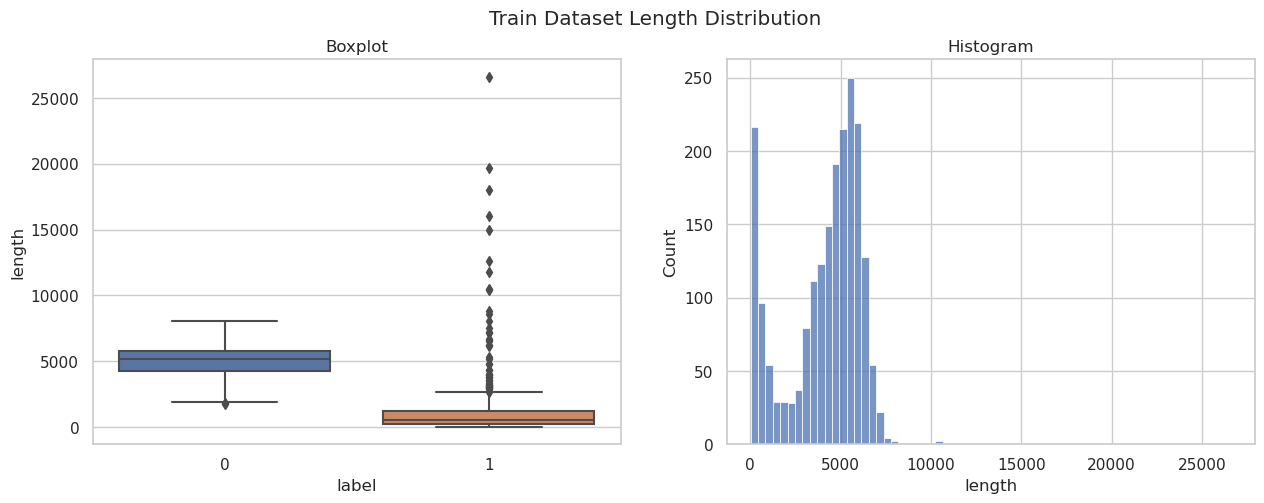

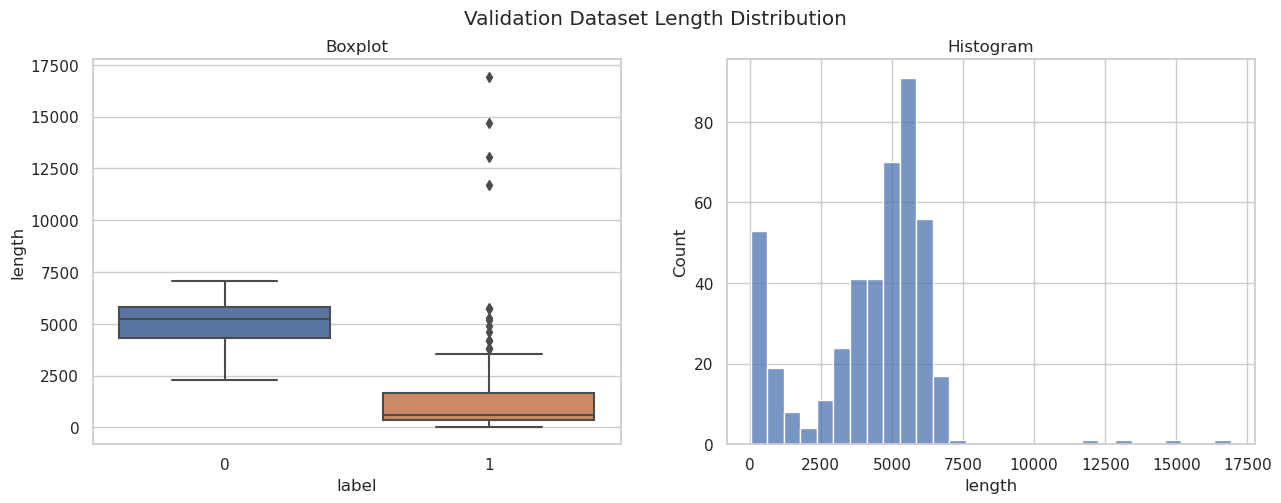

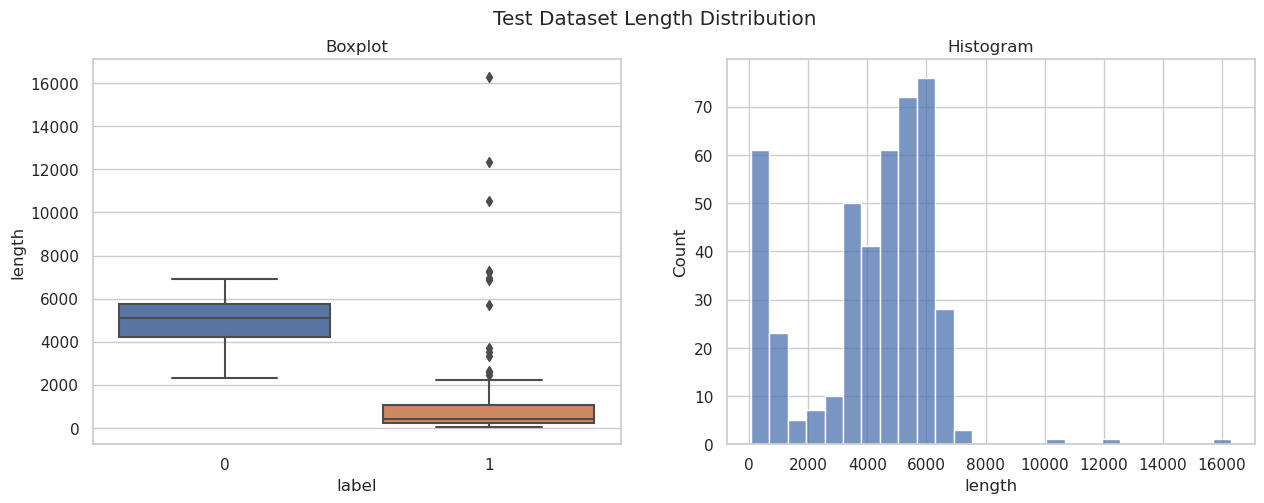

In [93]:
# plot the distribution of the length of the data samples in the train_set, val_set and test_set
plot_length_distribution(train_set, 'Train Dataset Length Distribution')
plot_length_distribution(val_set, 'Validation Dataset Length Distribution')
plot_length_distribution(test_set, 'Test Dataset Length Distribution')

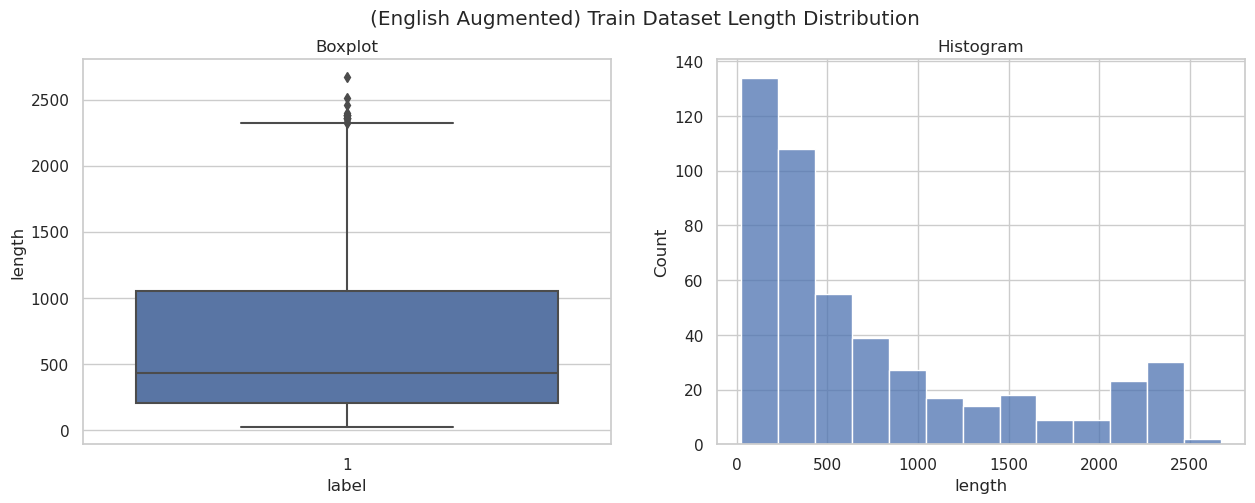

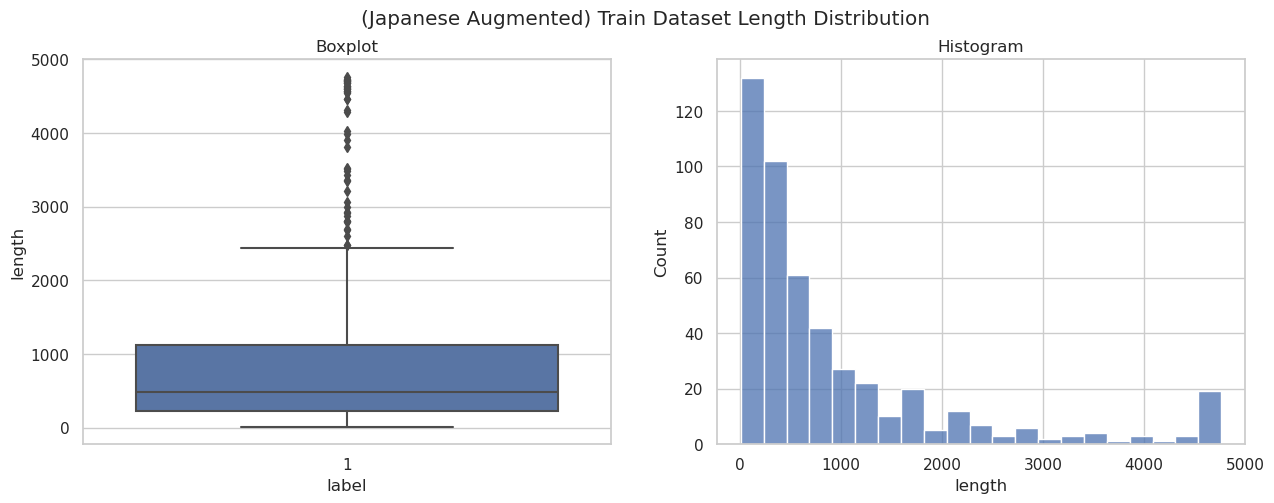

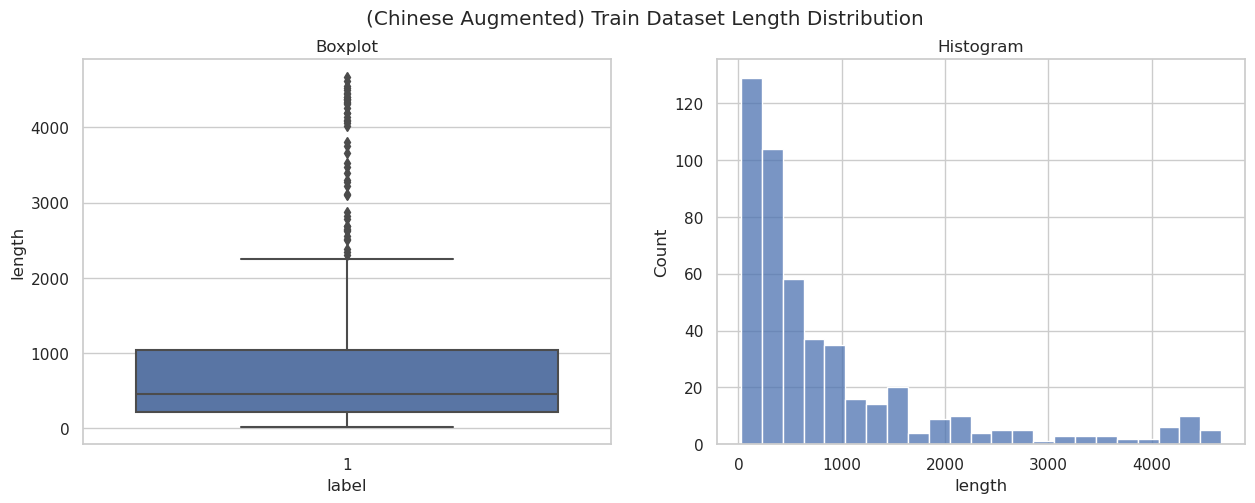

In [94]:
# plot the distribution of the length of the data samples in the train_set_en, train_set_ja and train_set_ch
plot_length_distribution(train_set_en, '(English Augmented) Train Dataset Length Distribution')
plot_length_distribution(train_set_ja, '(Japanese Augmented) Train Dataset Length Distribution')
plot_length_distribution(train_set_ch, '(Chinese Augmented) Train Dataset Length Distribution')

# Morphology Analyzer Installation

## Installation of Mecab-ko-for-GoogleColab

In [95]:
# Check if Mecab-ko-for-GoogleColab is installed. If not, install it.
try:
    from konlpy.tag import Mecab
except:
    print('Mecab-ko-for-GoogleColab is not installed. Installing...')
    subprocess.check_call(['bash', './install_mecab-ko_on_colab190912.sh'])
    print('Mecab-ko-for-GoogleColab installed.')


# if not os.path.exists('/content/Mecab-ko-for-Google-Colab'):
#     print('Installing Mecab-ko-for-Google-Colab...')
#     !git clone

## Testing MeCab

In [96]:
# Test MeCab and test morphological analysis on a sample sentence in Korean language (한국어)
mecab = Mecab()
print(mecab.morphs('한국어 형태소 분석기 테스트 중 입니다.'))

['한국어', '형태소', '분석기', '테스트', '중', '입니다', '.']


In [97]:
# test pos tagging
print(mecab.pos('한국어 형태소 분석기 테스트 중 입니다.'))

[('한국어', 'NNG'), ('형태소', 'NNG'), ('분석기', 'NNG'), ('테스트', 'NNG'), ('중', 'NNB'), ('입니다', 'VCP+EF'), ('.', 'SF')]


# Dataset Preprocessing

## Dataset cleaning and purification

In [98]:

# function to perform the cleaning parts
def apply_replacement(src_df, replace_func):
    ret_df = src_df
    ret_df['transcript'] = ret_df['transcript'].apply(lambda x: replace_func(x))
    return ret_df

# remove the unwanted word and characters from the dataset
def word_replace(x):
    example_word_replace_list = {'o/': '',
                                 'b/': '',
                                 'n/': '',
                                 '\n': ' ',
                                 'name': '',
                                 'laughing': '',
                                 'clearing': '',
                                 'singing': '',
                                 'applauding': ''}
    for i in example_word_replace_list:
        x = x.replace(i, example_word_replace_list[i])
    return x

# remove the special character from the transcripts
def remove_special_sysmbols(sentence): 
    sentence = re.sub(r"[-~=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]", '', sentence)
    return sentence

# remove x and O from the transcripts
def replace_x_o(sentence):
    
    # sentence = re.sub(r"(o{2,})|(O{2,})|(\ㅇ{2,})|(0{2,})|(x{2,})", '' , sentence)
    # sentence = re.sub(r"x{2,}", '' , sentence)
    # sentence = re.sub(r"0{2,}", '' , sentence)
    # sentence = re.sub(r"ㅇ{2,}", '' , sentence)
    # sentence = re.sub(r"O{2,}", '' , sentence)
    # sentence = re.sub(r"o{2,}", '' , sentence)
    sentence = re.sub(r"(o|O|\ㅇ|0|x){2,}", '' , sentence)
    return sentence

# remove the unwanted word and characters from the transcripts
def nline_replace(x):
    example_word_replace_list = {'\n' : ' '}
    for i in example_word_replace_list:
        x = x.replace(i, example_word_replace_list[i])
    return x

# remove extra whote space
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

In [99]:
# Clear the train_set using the function defined above
train_set['transcript_clean'] = train_set['transcript'].apply(lambda x: word_replace(x))
train_set['transcript_clean'] = train_set['transcript_clean'].apply(lambda x: remove_special_sysmbols(x))
train_set['transcript_clean'] = train_set['transcript_clean'].apply(lambda x: replace_x_o(x))
train_set['transcript_clean'] = train_set['transcript_clean'].apply(lambda x: nline_replace(x))
train_set['transcript_clean'] = train_set['transcript_clean'].apply(lambda x: remove_extra_white_spaces(x))
train_set['length_transcript_clean'] = train_set['transcript_clean'].apply(lambda x: len(x))

In [100]:
# Clear the val_set using the function defined above
val_set['transcript_clean'] = val_set['transcript'].apply(lambda x: word_replace(x))
val_set['transcript_clean'] = val_set['transcript_clean'].apply(lambda x: remove_special_sysmbols(x))
val_set['transcript_clean'] = val_set['transcript_clean'].apply(lambda x: replace_x_o(x))
val_set['transcript_clean'] = val_set['transcript_clean'].apply(lambda x: nline_replace(x))
val_set['transcript_clean'] = val_set['transcript_clean'].apply(lambda x: remove_extra_white_spaces(x))
val_set['length_transcript_clean'] = val_set['transcript_clean'].apply(lambda x: len(x))

In [101]:
# Clear the test_set using the function defined above
test_set['transcript_clean'] = test_set['transcript'].apply(lambda x: word_replace(x))
test_set['transcript_clean'] = test_set['transcript_clean'].apply(lambda x: remove_special_sysmbols(x))
test_set['transcript_clean'] = test_set['transcript_clean'].apply(lambda x: replace_x_o(x))
test_set['transcript_clean'] = test_set['transcript_clean'].apply(lambda x: nline_replace(x))
test_set['transcript_clean'] = test_set['transcript_clean'].apply(lambda x: remove_extra_white_spaces(x))
test_set['length_transcript_clean'] = test_set['transcript_clean'].apply(lambda x: len(x))

In [102]:
# Clear the train_set_en using the function defined above
train_set_en['transcript_clean_en'] = train_set_en['transcript_en'].apply(lambda x: word_replace(x))
train_set_en['transcript_clean_en'] = train_set_en['transcript_clean_en'].apply(lambda x: remove_special_sysmbols(x))
train_set_en['transcript_clean_en'] = train_set_en['transcript_clean_en'].apply(lambda x: replace_x_o(x))
train_set_en['transcript_clean_en'] = train_set_en['transcript_clean_en'].apply(lambda x: nline_replace(x))
train_set_en['transcript_clean_en'] = train_set_en['transcript_clean_en'].apply(lambda x: remove_extra_white_spaces(x))
train_set_en['length_transcript_clean_en'] = train_set_en['transcript_clean_en'].apply(lambda x: len(x))

In [103]:
# Clear the train_set_ja using the function defined above
train_set_ja['transcript_clean_ja'] = train_set_ja['transcript_ja'].apply(lambda x: word_replace(x))
train_set_ja['transcript_clean_ja'] = train_set_ja['transcript_clean_ja'].apply(lambda x: remove_special_sysmbols(x))
train_set_ja['transcript_clean_ja'] = train_set_ja['transcript_clean_ja'].apply(lambda x: replace_x_o(x))
train_set_ja['transcript_clean_ja'] = train_set_ja['transcript_clean_ja'].apply(lambda x: nline_replace(x))
train_set_ja['transcript_clean_ja'] = train_set_ja['transcript_clean_ja'].apply(lambda x: remove_extra_white_spaces(x))
train_set_ja['length_transcript_clean_ja'] = train_set_ja['transcript_clean_ja'].apply(lambda x: len(x))

In [104]:
# Clear the train_set_ch using the function defined above
train_set_ch['transcript_clean_ch'] = train_set_ch['transcript_ch'].apply(lambda x: word_replace(x))
train_set_ch['transcript_clean_ch'] = train_set_ch['transcript_clean_ch'].apply(lambda x: remove_special_sysmbols(x))
train_set_ch['transcript_clean_ch'] = train_set_ch['transcript_clean_ch'].apply(lambda x: replace_x_o(x))
train_set_ch['transcript_clean_ch'] = train_set_ch['transcript_clean_ch'].apply(lambda x: nline_replace(x))
train_set_ch['transcript_clean_ch'] = train_set_ch['transcript_clean_ch'].apply(lambda x: remove_extra_white_spaces(x))
train_set_ch['length_transcript_clean_ch'] = train_set_ch['transcript_clean_ch'].apply(lambda x: len(x))


In [105]:
# display the heads of the dataframes
train_set.head()

,transcript,label,length,transcript_clean,length_transcript_clean
0,크리스마스 식탁 위에 빠지지 않고 등장하는 존재가 있어. 하얀 생크림 시트 위에 형...,0,3128,크리스마스 식탁 위에 빠지지 않고 등장하는 존재가 있어 하얀 생크림 시트 위에 형형...,3067
1,어~ 혹시 씨는 가족 관계가 어떻게 돼요? 저희 가족은 다섯 명으로 이루어져 있는...,0,6280,어 혹시 씨는 가족 관계가 어떻게 돼요 저희 가족은 다섯 명으로 이루어져 있는데요...,6132
2,음~ 먹거리라는 주제를 가지고 얘기를 해 보고 싶어요. 선생님 요즘에 여름이라서 식...,0,5507,음 먹거리라는 주제를 가지고 얘기를 해 보고 싶어요 선생님 요즘에 여름이라서 식구들...,5320
3,통화 가능하십니까 어디서 봐요 예 지금 통화 괜찮으시죠 예 혹시 주변에 아는 사람들...,1,897,통화 가능하십니까 어디서 봐요 예 지금 통화 괜찮으시죠 예 혹시 주변에 아는 사람들...,879
4,네이버에 중고나라 사이트 아시죠? 대구지역 있으세요 아시죠? 사이트에서 김재원 일단...,1,416,네이버에 중고나라 사이트 아시죠 대구지역 있으세요 아시죠 사이트에서 김재원 일단은 ...,406


In [106]:
# display the heads of the dataframes
val_set.head()

,transcript,label,length,transcript_clean,length_transcript_clean
0,살면서 선물을 받아 보셨나요? 누구에게 받은 선물이 제일 기뻤나요? 아무래도 살아온...,0,5221,살면서 선물을 받아 보셨나요 누구에게 받은 선물이 제일 기뻤나요 아무래도 살아온 시...,5122
1,요즘 코로나 때문에 우리가 영화관에 못 가잖아. 그래서 며칟날 보던 거기 사이트에서...,0,6653,요즘 코로나 때문에 우리가 영화관에 못 가잖아 그래서 며칟날 보던 거기 사이트에서 ...,6380
2,몇 가지 확인 할 상황이 있어서 연락 되시면 지금 통화 가능하겠습니까? 단순한 사 ...,1,347,몇 가지 확인 할 상황이 있어서 연락 되시면 지금 통화 가능하겠습니까 단순한 사 올...,338
3,어~ 혹시 좋아하는 음식 종류가 한식 양식 중식 일식 중에 어떤 걸 가장 좋아하시나...,0,4259,어 혹시 좋아하는 음식 종류가 한식 양식 중식 일식 중에 어떤 걸 가장 좋아하시나요...,4133
4,너는 좋아하는 계절이나 날씨가 있어? 우선 내가 좋아하는 계절은 음~ 가을 봄 두 ...,0,4588,너는 좋아하는 계절이나 날씨가 있어 우선 내가 좋아하는 계절은 음 가을 봄 두 개를...,4515


In [107]:
# display the heads of the dataframes
test_set.head()

,transcript,label,length,transcript_clean,length_transcript_clean
0,님한테 가족이라는 것은 어떤 의미인지 가족을 어떻게 정의하고 있는지 말씀해 주세요...,0,4151,님한테 가족이라는 것은 어떤 의미인지 가족을 어떻게 정의하고 있는지 말씀해 주세요...,4063
1,어~ 크리스마스 때 내가 선물로 이제 친구들끼리 이제 재미로 황당하지만 재밌는 선...,0,6200,어 크리스마스 때 내가 선물로 이제 친구들끼리 이제 재미로 황당하지만 재밌는 선물...,5999
2,찜질방 차리면서 본인에게 연락을 드린 정확한 이유는요? 불법 현장에서 본인 명의로 ...,1,326,찜질방 차리면서 본인에게 연락을 드린 정확한 이유는요 불법 현장에서 본인 명의로 된...,317
3,나는 오빠 밖에 없잖아. 오빠 오빠랑 인제 아버지는 일찍 돌아가셔서 엄마랑 오빠가 ...,0,5155,나는 오빠 밖에 없잖아 오빠 오빠랑 인제 아버지는 일찍 돌아가셔서 엄마랑 오빠가 친...,5024
4,혹시 장래 희망이 어떻게 되세요? 저는 부모님이 바라는 장래 희망과 제가 바라는 장...,0,4311,혹시 장래 희망이 어떻게 되세요 저는 부모님이 바라는 장래 희망과 제가 바라는 장래...,4231


In [108]:
# display the heads of the dataframes
train_set_en.head()

,transcript_en,label,length,transcript_clean_en,length_transcript_clean_en
3,시간 있으세요? 어디에서 만나죠? 괜찮아요? 당신 주변에서 제가 감정적인 사람을 본...,1,869,시간 있으세요 어디에서 만나죠 괜찮아요 당신 주변에서 제가 감정적인 사람을 본 적이...,837
4,네이버 중고나라 사이트 아시죠? 대구에 한 곳이 있습니다. 알고 있죠? 김재원 씨는...,1,328,네이버 중고나라 사이트 아시죠 대구에 한 곳이 있습니다 알고 있죠 김재원 씨는 현장...,317
7,"안녕하세요 안녕하세요 아 네, 기간은 5년 7080 bad입니다. 지금도 매일 36...",1,246,안녕하세요 안녕하세요 아 네 기간은 5년 7080 bad입니다 지금도 매일 3632...,227
8,"본인이 직접 갚아야 할 경우에는 그 내용이 포함됩니다. 또한 5002,029 Ya...",1,209,본인이 직접 갚아야 할 경우에는 그 내용이 포함됩니다 또한 52029 Ya의 공증...,193
10,다른 멤버들은 지금 당장은 안 되는데 언제쯤 가능할까요.,1,32,다른 멤버들은 지금 당장은 안 되는데 언제쯤 가능할까요,31


In [109]:
# display the heads of the dataframes
train_set_ja.head()

,transcript_ja,label,length,transcript_clean_ja,length_transcript_clean_ja
3,"통화 가능한가요?어디서 만나요. 네, 지금 통화 괜찮죠? 주변 지인들이 본 적 있나...",1,846,통화 가능한가요어디서 만나요 네 지금 통화 괜찮죠 주변 지인들이 본 적 있나요 감정...,819
4,"네이버 중고나라 사이트 아시죠? 대구 지역 있어요.아시죠? 사이트에서 김재원, 일단...",1,391,네이버 중고나라 사이트 아시죠 대구 지역 있어요아시죠 사이트에서 김재원 일단은 그렇...,380
7,"여보세요, 여보세요, 아, 네, 또는 기간을 5년 만에 7080이나 나쁘고 지금도 ...",1,1278,여보세요 여보세요 아 네 또는 기간을 5년 만에 7080이나 나쁘고 지금도 매일 3...,1222
8,"네, OOO 고객님? 네, 상담사 김정훈 대리입니다 고객님의 소득만을 담보로 대출을...",1,3810,네 고객님 네 상담사 김정훈 대리입니다 고객님의 소득만을 담보로 대출을 받기 때문...,3669
10,말씀해주세요\n일하셨어요? 해지된 시간을 알려주시겠어요?\n해지한 시간이요?\n네。...,1,973,말씀해주세요 일하셨어요 해지된 시간을 알려주시겠어요 해지한 시간이요 네。 일시적으로...,907


In [110]:
# display the heads of the dataframes
train_set_ch.head()

,transcript_ch,label,length,transcript_clean_ch,length_transcript_clean_ch
3,통화할 수 있을까요? 어디서 만날까요?지금 통화는 괜찮으시죠?혹시 주변에 아는 사람...,1,779,통화할 수 있을까요 어디서 만날까요지금 통화는 괜찮으시죠혹시 주변에 아는 사람 있나...,748
4,네이버 중고나라 사이트 아시죠? 대구 지역이 있나요? 홈페이지에서 김재원이 먼저 나...,1,358,네이버 중고나라 사이트 아시죠 대구 지역이 있나요 홈페이지에서 김재원이 먼저 나라 ...,346
7,"야, 야, 아예 만기를 5년, 7080으로 못되게 해서 지금 하루 36만 3255r...",1,1220,야 야 아예 만기를 5년 7080으로 못되게 해서 지금 하루 36만 3255r28 ...,1162
8,OOO고객님? 저는 상담사 김정훈 대리입니다 고객님의 소득만을 담보로 대출을 진행하...,1,3522,고객님 저는 상담사 김정훈 대리입니다 고객님의 소득만을 담보로 대출을 진행하기 때문...,3351
10,"말씀하세요.\n일은 하셨나요, 취소하시는 시간을 알려주시겠어요?\n해지하는 시간이요...",1,989,말씀하세요 일은 하셨나요 취소하시는 시간을 알려주시겠어요 해지하는 시간이요 네 1시...,922


## Remove the Korean stop words



In [111]:
# import the Korean stop words
# stop_words = pd.read_csv('korean_stopwords.csv')
# stop_words = stop_words['stopwords'].tolist()

In [112]:
# # remove the Korean stop words from the train_set
# train_set['transcript_clean'] = train_set['transcript_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# train_set['length_transcript_clean'] = train_set['transcript_clean'].apply(lambda x: len(x))

In [113]:
## remove the stop word
stopwords = ["을", "를", "이", "가", "ㅡ", "은", "는", "XXX", "xxx", "어요", "아니", "입니다", "에서", "니까", "으로",
             "근데", "습니다", "습니까", "저희", "합니다", "하고", "싶어요", "있는", "있습니다", "싶습니다", "그냥",
             "고요", "에요", "예요", "으시", "그래서"]

# open and read the file containing comprehensive stopwords 
# stopwords_all = open("stopwords-ko.txt").readlines()

# function to remove the stop word from the train and test dataframe
def get_model_input(_words):
    global stopwords
    _words = [x for x in _words if x[0] not in stopwords]
    _words = [x for x in _words if x[:-1] not in stopwords]

    for i in range(len(_words)-1):
        yield _words[i]

In [114]:
def get_corpus(df):
    corpus = []
    for lwords in df:    
        temp = []
        for x in get_model_input(lwords):
            if len(x) != 1:
                temp.append("{}".format(x))
        corpus.append(" ".join(temp))
    return corpus        

In [115]:
from konlpy.tag import Mecab
mecab = Mecab()

train_set_corpus = get_corpus([(mecab.morphs(x)) for x in train_set['transcript_clean']])
val_set_corpus = get_corpus([(mecab.morphs(x)) for x in val_set['transcript_clean']])
test_set_corpus = get_corpus([(mecab.morphs(x)) for x in test_set['transcript_clean']])

train_set_en_corpus = get_corpus([(mecab.morphs(x)) for x in train_set_en['transcript_clean_en']])
train_set_ja_corpus = get_corpus([(mecab.morphs(x)) for x in train_set_ja['transcript_clean_ja']])
train_set_ch_corpus = get_corpus([(mecab.morphs(x)) for x in train_set_ch['transcript_clean_ch']])


In [116]:
# adding the corpus to the dataframe
train_set['corpus'] = train_set_corpus
val_set['corpus'] = val_set_corpus
test_set['corpus'] = test_set_corpus

# adding the corpus to the dataframe
train_set_en['corpus_en'] = train_set_en_corpus
train_set_ja['corpus_ja'] = train_set_ja_corpus
train_set_ch['corpus_ch'] = train_set_ch_corpus

In [117]:
# add the length of the corpus to the dataframe
train_set['length_corpus'] = train_set['corpus'].apply(lambda x: len(x))
val_set['length_corpus'] = val_set['corpus'].apply(lambda x: len(x))
test_set['length_corpus'] = test_set['corpus'].apply(lambda x: len(x))

# add the length of the corpus to the dataframe
train_set_en['length_corpus_en'] = train_set_en['corpus_en'].apply(lambda x: len(x))
train_set_ja['length_corpus_ja'] = train_set_ja['corpus_ja'].apply(lambda x: len(x))
train_set_ch['length_corpus_ch'] = train_set_ch['corpus_ch'].apply(lambda x: len(x))


In [118]:
# display the heads of the dataframes
train_set.head()


,transcript,label,length,transcript_clean,length_transcript_clean,corpus,length_corpus
0,크리스마스 식탁 위에 빠지지 않고 등장하는 존재가 있어. 하얀 생크림 시트 위에 형...,0,3128,크리스마스 식탁 위에 빠지지 않고 등장하는 존재가 있어 하얀 생크림 시트 위에 형형...,3067,크리스마스 식탁 빠지 등장 존재 하얀 생크림 시트 형형색색 화려 올린 크리스마스 케...,1969
1,어~ 혹시 씨는 가족 관계가 어떻게 돼요? 저희 가족은 다섯 명으로 이루어져 있는...,0,6280,어 혹시 씨는 가족 관계가 어떻게 돼요 저희 가족은 다섯 명으로 이루어져 있는데요...,6132,혹시 관계 어떻게 돼요 저희 다섯 으로 동생 엄마 아빠 다섯 에요 저희 엄마 정말 ...,3559
2,음~ 먹거리라는 주제를 가지고 얘기를 해 보고 싶어요. 선생님 요즘에 여름이라서 식...,0,5507,음 먹거리라는 주제를 가지고 얘기를 해 보고 싶어요 선생님 요즘에 여름이라서 식구들...,5320,먹거리 라는 주제 얘기 어요 선생 요즘 여름 라서 식구 입맛 조금 떨어지 밥맛 시기...,3268
3,통화 가능하십니까 어디서 봐요 예 지금 통화 괜찮으시죠 예 혹시 주변에 아는 사람들...,1,897,통화 가능하십니까 어디서 봐요 예 지금 통화 괜찮으시죠 예 혹시 주변에 아는 사람들...,879,통화 십니까 어디 봐요 지금 통화 괜찮 으시 혹시 주변 사람 으세요 감정 으로 출신...,635
4,네이버에 중고나라 사이트 아시죠? 대구지역 있으세요 아시죠? 사이트에서 김재원 일단...,1,416,네이버에 중고나라 사이트 아시죠 대구지역 있으세요 아시죠 사이트에서 김재원 일단은 ...,406,네이버 중고 나라 사이트 대구 지역 으세요 사이트 에서 김재원 일단 그리 국가 물건...,286


In [119]:
# display the heads of the dataframes
val_set.head()

,transcript,label,length,transcript_clean,length_transcript_clean,corpus,length_corpus
0,살면서 선물을 받아 보셨나요? 누구에게 받은 선물이 제일 기뻤나요? 아무래도 살아온...,0,5221,살면서 선물을 받아 보셨나요 누구에게 받은 선물이 제일 기뻤나요 아무래도 살아온 시...,5122,면서 선물 나요 누구 에게 선물 제일 기뻤 나요 아무래도 살아온 시간 으니까 선물 ...,3105
1,요즘 코로나 때문에 우리가 영화관에 못 가잖아. 그래서 며칟날 보던 거기 사이트에서...,0,6653,요즘 코로나 때문에 우리가 영화관에 못 가잖아 그래서 며칟날 보던 거기 사이트에서 ...,6380,요즘 코로나 때문 우리 영화관 잖아 그래서 며칟날 거기 사이트 에서 반도 더라고 강...,3898
2,몇 가지 확인 할 상황이 있어서 연락 되시면 지금 통화 가능하겠습니까? 단순한 사 ...,1,347,몇 가지 확인 할 상황이 있어서 연락 되시면 지금 통화 가능하겠습니까 단순한 사 올...,338,확인 상황 어서 연락 지금 통화 습니까 단순 연락 드린 아니 고요 여쭤볼 습니다 혹...,228
3,어~ 혹시 좋아하는 음식 종류가 한식 양식 중식 일식 중에 어떤 걸 가장 좋아하시나...,0,4259,어 혹시 좋아하는 음식 종류가 한식 양식 중식 일식 중에 어떤 걸 가장 좋아하시나요...,4133,혹시 음식 종류 한식 양식 중식 일식 어떤 나요 한식 음식 특별히 아서 모두 아무래...,2277
4,너는 좋아하는 계절이나 날씨가 있어? 우선 내가 좋아하는 계절은 음~ 가을 봄 두 ...,0,4588,너는 좋아하는 계절이나 날씨가 있어 우선 내가 좋아하는 계절은 음 가을 봄 두 개를...,4515,계절 날씨 우선 계절 좋아하 우선 좋아하 그렇게 그렇게 그리고 어서 그렇게 반팔 그...,2402


In [120]:
# display the heads of the dataframes   
test_set.head()

,transcript,label,length,transcript_clean,length_transcript_clean,corpus,length_corpus
0,님한테 가족이라는 것은 어떤 의미인지 가족을 어떻게 정의하고 있는지 말씀해 주세요...,0,4151,님한테 가족이라는 것은 어떤 의미인지 가족을 어떻게 정의하고 있는지 말씀해 주세요...,4063,한테 라는 어떤 의미 인지 어떻게 정의 말씀 세요 정의 라고 니까 어렵 라는 생각 ...,2455
1,어~ 크리스마스 때 내가 선물로 이제 친구들끼리 이제 재미로 황당하지만 재밌는 선...,0,6200,어 크리스마스 때 내가 선물로 이제 친구들끼리 이제 재미로 황당하지만 재밌는 선물...,5999,크리스마스 선물 친구 끼리 재미 황당 지만 재밌 선물 주기 고등학교 졸업 사진 액자...,3280
2,찜질방 차리면서 본인에게 연락을 드린 정확한 이유는요? 불법 현장에서 본인 명의로 ...,1,326,찜질방 차리면서 본인에게 연락을 드린 정확한 이유는요 불법 현장에서 본인 명의로 된...,317,찜질방 차리 면서 본인 에게 연락 드린 정확 불법 현장 에서 본인 명의 제일은행 통...,238
3,나는 오빠 밖에 없잖아. 오빠 오빠랑 인제 아버지는 일찍 돌아가셔서 엄마랑 오빠가 ...,0,5155,나는 오빠 밖에 없잖아 오빠 오빠랑 인제 아버지는 일찍 돌아가셔서 엄마랑 오빠가 친...,5024,오빠 밖에 잖아 오빠 오빠 인제 아버지 일찍 돌아가 셔서 엄마 오빠 친정 식구 남편...,3058
4,혹시 장래 희망이 어떻게 되세요? 저는 부모님이 바라는 장래 희망과 제가 바라는 장...,0,4311,혹시 장래 희망이 어떻게 되세요 저는 부모님이 바라는 장래 희망과 제가 바라는 장래...,4231,혹시 장래 희망 어떻게 세요 부모 바라 장래 희망 바라 장래 희망 다른 부모 바라 ...,2628


In [121]:
# display the heads of the dataframes
train_set_en.head()

,transcript_en,label,length,transcript_clean_en,length_transcript_clean_en,corpus_en,length_corpus_en
3,시간 있으세요? 어디에서 만나죠? 괜찮아요? 당신 주변에서 제가 감정적인 사람을 본...,1,869,시간 있으세요 어디에서 만나죠 괜찮아요 당신 주변에서 제가 감정적인 사람을 본 적이...,837,시간 으세요 어디 에서 만나 괜찮 아요 당신 주변 에서 감정 사람 나요 당신 당신 ...,592
4,네이버 중고나라 사이트 아시죠? 대구에 한 곳이 있습니다. 알고 있죠? 김재원 씨는...,1,328,네이버 중고나라 사이트 아시죠 대구에 한 곳이 있습니다 알고 있죠 김재원 씨는 현장...,317,네이버 중고 나라 사이트 대구 습니다 김재원 현장 에서 나라 물건 위해 매물 내놓 ...,207
7,"안녕하세요 안녕하세요 아 네, 기간은 5년 7080 bad입니다. 지금도 매일 36...",1,246,안녕하세요 안녕하세요 아 네 기간은 5년 7080 bad입니다 지금도 매일 3632...,227,안녕 세요 안녕 세요 기간 7080 bad 입니다 지금 매일 363255 28 정부...,171
8,"본인이 직접 갚아야 할 경우에는 그 내용이 포함됩니다. 또한 5002,029 Ya...",1,209,본인이 직접 갚아야 할 경우에는 그 내용이 포함됩니다 또한 52029 Ya의 공증...,193,본인 직접 아야 경우 내용 포함 됩니다 또한 52029 Ya 공증 비용 개월 연체 ...,138
10,다른 멤버들은 지금 당장은 안 되는데 언제쯤 가능할까요.,1,32,다른 멤버들은 지금 당장은 안 되는데 언제쯤 가능할까요,31,다른 멤버 지금 당장 언제,14


In [122]:
# display the heads of the dataframes
train_set_ja.head()

,transcript_ja,label,length,transcript_clean_ja,length_transcript_clean_ja,corpus_ja,length_corpus_ja
3,"통화 가능한가요?어디서 만나요. 네, 지금 통화 괜찮죠? 주변 지인들이 본 적 있나...",1,846,통화 가능한가요어디서 만나요 네 지금 통화 괜찮죠 주변 지인들이 본 적 있나요 감정...,819,통화 한가요 어디 만나 지금 통화 괜찮 주변 지인 나요 감정상 출신 인데 자막 들어...,629
4,"네이버 중고나라 사이트 아시죠? 대구 지역 있어요.아시죠? 사이트에서 김재원, 일단...",1,391,네이버 중고나라 사이트 아시죠 대구 지역 있어요아시죠 사이트에서 김재원 일단은 그렇...,380,네이버 중고 나라 사이트 대구 지역 어요 사이트 에서 김재원 일단 그렇 물건 다고 ...,255
7,"여보세요, 여보세요, 아, 네, 또는 기간을 5년 만에 7080이나 나쁘고 지금도 ...",1,1278,여보세요 여보세요 아 네 또는 기간을 5년 만에 7080이나 나쁘고 지금도 매일 3...,1222,여보세요 여보세요 또는 기간 7080 나쁘 지금 매일 36 3255 28 정부 지원...,893
8,"네, OOO 고객님? 네, 상담사 김정훈 대리입니다 고객님의 소득만을 담보로 대출을...",1,3810,네 고객님 네 상담사 김정훈 대리입니다 고객님의 소득만을 담보로 대출을 받기 때문...,3669,고객 담사 김정훈 대리 입니다 고객 소득 담보 대출 때문 관련 해서 대출 계약서 특...,2591
10,말씀해주세요\n일하셨어요? 해지된 시간을 알려주시겠어요?\n해지한 시간이요?\n네。...,1,973,말씀해주세요 일하셨어요 해지된 시간을 알려주시겠어요 해지한 시간이요 네。 일시적으로...,907,말씀 세요 어요 해지 시간 알려 어요 해지 시간 일시 으로 입니다 13 다시 말씀 ...,697


In [123]:
# display the heads of the dataframes
train_set_ch.head()

,transcript_ch,label,length,transcript_clean_ch,length_transcript_clean_ch,corpus_ch,length_corpus_ch
3,통화할 수 있을까요? 어디서 만날까요?지금 통화는 괜찮으시죠?혹시 주변에 아는 사람...,1,779,통화할 수 있을까요 어디서 만날까요지금 통화는 괜찮으시죠혹시 주변에 아는 사람 있나...,748,통화 어디 만날까요 지금 통화 괜찮 으시 혹시 주변 사람 나요 감정 출신 인데 자막...,560
4,네이버 중고나라 사이트 아시죠? 대구 지역이 있나요? 홈페이지에서 김재원이 먼저 나...,1,358,네이버 중고나라 사이트 아시죠 대구 지역이 있나요 홈페이지에서 김재원이 먼저 나라 ...,346,네이버 중고 나라 사이트 대구 지역 나요 홈페이지 에서 김재원 먼저 나라 물건 판다...,245
7,"야, 야, 아예 만기를 5년, 7080으로 못되게 해서 지금 하루 36만 3255r...",1,1220,야 야 아예 만기를 5년 7080으로 못되게 해서 지금 하루 36만 3255r28 ...,1162,아예 만기 7080 으로 해서 지금 하루 36 3255 28 정부 지원금 으로 국민...,809
8,OOO고객님? 저는 상담사 김정훈 대리입니다 고객님의 소득만을 담보로 대출을 진행하...,1,3522,고객님 저는 상담사 김정훈 대리입니다 고객님의 소득만을 담보로 대출을 진행하기 때문...,3351,고객 상담 김정훈 대리 입니다 고객 소득 담보 대출 진행 때문 대출계 약서 특약 사...,2393
10,"말씀하세요.\n일은 하셨나요, 취소하시는 시간을 알려주시겠어요?\n해지하는 시간이요...",1,989,말씀하세요 일은 하셨나요 취소하시는 시간을 알려주시겠어요 해지하는 시간이요 네 1시...,922,말씀 세요 나요 취소 시간 알려 어요 해지 시간 10 입니다 다시 말씀 어요 13 ...,721


In [124]:
# save the train_set, val_set and test_set to csv files
train_set.to_csv('train_set_clean.csv', index=False)
val_set.to_csv('val_set_clean.csv', index=False)
test_set.to_csv('test_set_clean.csv', index=False)

# save the train_set_en, train_set_ja and train_set_ch to csv files
train_set_en.to_csv('train_set_en_clean.csv', index=False)
train_set_ja.to_csv('train_set_ja_clean.csv', index=False)
train_set_ch.to_csv('train_set_ch_clean.csv', index=False)


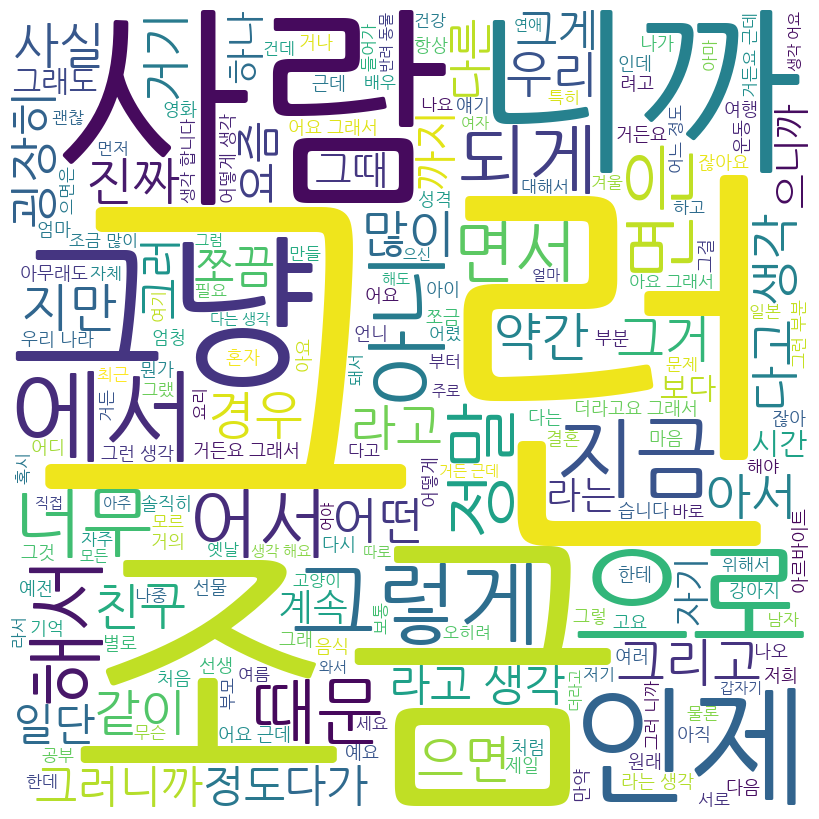

In [125]:
# plot the word cloud of the train_set corpus with Korean font 
wordcloud = WordCloud(font_path='NanumGothic.ttf', width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(' '.join(train_set['corpus']))

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Vectorization of the dataset

In [126]:
def vectorize_dataset(df_train, df_test, df_validation):
    # Convert a collection of raw documents to a matrix of TF-IDF features.
    tfidf = TfidfVectorizer(# analyzer='word', # default='word'
                            ngram_range=(1, 3), #(2, 6), # 3,6
                            max_df=0.5, #ignoring terms that have a document frequency higher than 0.5
                            # min_df=2, # 10
                            max_features=2000, #300, 500, 10000 (this will limit the vocabulary)
                            sublinear_tf=True, #replaces tf with 1 + log(tf), twenty occurrences of a term in a document
                                                #does not represent twenty times the significance of a single occurrence
                            use_idf=True
    )

    #Converting the sparse matrix into an array
    #We then apply the toarray function to convert the sparse matrix into an array.
    X_train = tfidf.fit_transform(df_train['corpus']).toarray()
    X_test = tfidf.transform(df_test['corpus']).toarray()
    X_validation = tfidf.fit_transform(df_validation['corpus']).toarray()

    y_train, y_validation, y_test = df_train['label'], df_validation['label'], df_test['label']
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [127]:
# vectorize the dataset
X_train, X_validation, X_test, y_train, y_validation, y_test = vectorize_dataset(train_set, test_set, val_set)

#set the evaluation set for early stop models
eval_set = [(X_validation, y_validation)]

# Training ML models with imbalanced dataset

## TRAINING CODE 1

In [128]:
# # function to train the ML models
# def train_ml_model(X_train, X_validation, X_test, y_train, y_validation, y_test, model):
#     start = timer()
#     model[1].fit(X_train, y_train)
#     end = timer()
#     training_time = end - start
#     y_pred = model[1].predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average='macro')
#     recall = recall_score(y_test, y_pred, average='macro')
#     f1 = f1_score(y_test, y_pred, average='macro')
#     f2 = fbeta_score(y_test, y_pred, beta=2.0, average='macro')
#     roc_auc = roc_auc_score(y_test, y_pred, average='macro')
#     matthews_corrcoef = matthews_corrcoef(y_test, y_pred)
#     cohen_kappa = cohen_kappa_score(y_test, y_pred)
#     cm = confusion_matrix(y_test, y_pred)
#     cr = classification_report(y_test, y_pred)
#     return training_time, accuracy, precision, recall, f1, f2, roc_auc, matthews_corrcoef, cohen_kappa, cm, cr

In [129]:
# def train_ml_model(X_train, X_validation, X_test, y_train, y_validation, y_test, model):
#     # start the timer
#     start = timer()
#     
#     # fit the model
#     model.fit(X_train, y_train)
#     
#     # make predictions for test data
#     y_pred = model.predict(X_test)
#     
#     # stop the timer
#     end = timer()
#     
#     # calculate the training time
#     training_time = end - start
#     
#     # calculate the accuracy score
#     accuracy = accuracy_score(y_test, y_pred)
#     
#     # calculate the precision score
#     precision = precision_score(y_test, y_pred, average='macro')
#     
#     # calculate the recall score
#     recall = recall_score(y_test, y_pred, average='macro')
#     
#     # calculate the f1 score
#     f1 = f1_score(y_test, y_pred, average='macro')
#     
#     # calculate the f2 score
#     f2 = fbeta_score(y_test, y_pred, average='macro', beta=2.0)
#     
#     # calculate the roc auc score
#     roc_auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovo')
#     
#     # calculate the matthews correlation coefficient
#     matthews_corrcoef = matthews_corrcoef(y_test, y_pred)
#     
#     # calculate the cohen kappa score
#     cohen_kappa = cohen_kappa_score(y_test, y_pred)
#     
#     # calculate the confusion matrix
#     cm = confusion_matrix(y_test, y_pred)
#     
#     # calculate the classification report
#     cr = classification_report(y_test, y_pred)
#     
#     # return the results
#     return training_time, accuracy, precision, recall, f1, f2, roc_auc, matthews_corrcoef, cohen_kappa, cm, cr

In [130]:
# # function to print the results
# def print_results(training_time, accuracy, precision, recall, f1, f2, roc_auc, matthews_corrcoef, cohen_kappa, cm, cr):
#     print('Training Time: ', training_time)
#     print('Accuracy: ', accuracy)
#     print('Precision: ', precision)
#     print('Recall: ', recall)
#     print('F1: ', f1)
#     print('F2: ', f2)
#     print('ROC AUC: ', roc_auc)
#     print('Matthews Corrcoef: ', matthews_corrcoef)
#     print('Cohen Kappa: ', cohen_kappa)
#     print('Confusion Matrix: \n', cm)
#     print('Classification Report: \n', cr)

In [131]:
# # define the ML models
# models = [
#     ('MultinomialNB', MultinomialNB()),
#     ('GaussianNB', GaussianNB()),
#     ('RandomForestClassifier', RandomForestClassifier()),
#     ('DecisionTreeClassifier', DecisionTreeClassifier()),
#     ('LogisticRegression', LogisticRegression()),
#     ('XGBClassifier', XGBClassifier()),
#     ('LGBMClassifier', LGBMClassifier()),
#     ('SVC', SVC())
# ]

In [132]:
# # train the ML models considering 'MultinomialNB' object is not subscriptable
# for name, model in models:
#     print('Training ', name, '...')
#     training_time, accuracy, precision, recall, f1, f2, roc_auc, matthews_corrcoef, cohen_kappa, cm, cr = train_ml_model(X_train, X_validation, X_test, y_train, y_validation, y_test, model)
#     print_results(training_time, accuracy, precision, recall, f1, f2, roc_auc, matthews_corrcoef, cohen_kappa, cm, cr)
#     print('Training ', name, 'completed.')
#     print('--------------------------------------------------')
# 
# # for name, model in models:
# #     print('Training ', name, '...')
# #     training_time, accuracy, precision, recall, f1, f2, roc_auc, matthews_corrcoef, cohen_kappa, cm, cr = train_ml_model(X_train, X_validation, X_test, y_train, y_validation, y_test, model)
# #     print_results(training_time, accuracy, precision, recall, f1, f2, roc_auc, matthews_corrcoef, cohen_kappa, cm, cr)
# #     print('Training ', name, 'completed.')
# #     print('--------------------------------------------------')

In [133]:
# # function to plot the confusion matrix
# def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
#     # plot the confusion matrix
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     
#     # plot the ticks
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)
#     
#     # plot the text
#     fmt = 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#             plt.text(j, i, format(cm[i, j], fmt),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")
#             
#     # plot the labels
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()

## TRAINING CODE 2

In [134]:
# def get_metrics(y_test, y_test_pred, y_test_proba, threshold=0.5):
#     # y_pred_class = y_test_proba > threshold
#     y_pred_class = y_test_pred
# 
#     tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
# 
#     true_positive_rate = tp / (tp + fn)
#     true_negative_rate = tn / (tn + fp)
#     positive_predictive_value = tp / (tp + fp)
#     negative_predictive_value = tn / (tn + fn)
#     false_positive_rate = fp / (fp + tn)
#     false_negative_rate = fn / (tp + fn)
#     false_discovery_rate = fp / (tp + fp)
# 
#     scores = {'Accuracy': accuracy_score(y_test, y_pred_class),
#               'Precision': precision_score(y_test, y_pred_class),
#               'Recall': recall_score(y_test, y_pred_class),
#               'F1_score': f1_score(y_test, y_pred_class),
#               'F05_score': fbeta_score(y_test, y_pred_class, beta=0.5),
#               'F2_score': fbeta_score(y_test, y_pred_class, beta=2),
#               'Roc auc score': roc_auc_score(y_test, y_test_proba),
#               'Matthews_corrcoef': matthews_corrcoef(y_test, y_pred_class),
#               'Cohen_kappa': cohen_kappa_score(y_test, y_pred_class),
#               'True_positive_rate': true_positive_rate,
#               'True_negative_rate': true_negative_rate,
#               'Positive_predictive_value': positive_predictive_value,
#               'Negative_predictive_value': negative_predictive_value,
#               'False_positive_rate': false_positive_rate,
#               'False_negative_rate': false_negative_rate,
#               'False_discovery_rate': false_discovery_rate,
#               }
# 
#     return scores

## Define the ML models

In [135]:
# # define the ML models
# def define_models():
#     models = [] #list to save the initiated models
#     
# #     # Gaussian Naive Bayes
# #     # gnb assumes them to be continuous
# #     gnb = GaussianNB()
# 
# #     # Mltinomial Naive Bayes
# #     # nb assumes the features are discrete
# #     mnb = MultinomialNB()
# 
# #     #logistic regression
# #     lr = LogisticRegression(
# #         # C=10,# random_state=1234
# #     )
# 
# #     #Decision Tree
#     dt = DecisionTreeClassifier(
#         # max_depth=10, 
#         # random_state=1234
#     )
# 
#     #Random Forest
#     rf = RandomForestClassifier(
#         # n_estimators=100,
#         # max_depth=20,
#         # max_features=0.06,
#         # n_jobs=6,
#         # random_state=1234
#     )
# 
#     #XGBoost
#     xgb = XGBClassifier(
#         early_stopping_rounds=10,
#         verbosity=2,
#         # n_estimators=2000,
#         # tree_method='hist',
#         # subsample=0.67,
#         # colsample_level=0.06,
#         # n_jobs=6,
#         # random_state=1234
#     )
# 
#     #LightGBM
#     lgbm = LGBMClassifier(
#         early_stopping_rounds=10,
#         verbosity=2,
#         # boost_from_average=False
#         # num_leaves=64,
#         # n_estimators=2000,
#         # feature_fraction=0.06,
#         # bagging_fraction=0.67,
#         # bagging_freq=1,
#         # n_jobs=6,
#         # random_state=1234
#     )
#     
#     #add the models in the list
#     models = [dt, rf, xgb, lgbm]
#     
#     # #to specify which of our models require early stopping within the .fit() method.
#     es_models = ['XGBClassifier', 'LGBMClassifier']
#     
#     return models, es_models

## Train the ML models

In [136]:
# # train the ML models
# def train_models(models, es_models, X_train, X_test, y_train, y_test, eval_set):
#     # dictionary to save the results
#     results = {}
#     
#     # loop through the models
#     for model in models:
#         # get the name of the model
#         name = model.__class__.__name__
#         
#         # check if the model requires early stopping
#         if name in es_models:
#             # fit the model
#             model.fit(X_train, y_train, eval_set=eval_set)
#         else:
#             # fit the model
#             model.fit(X_train, y_train)
#         
#         # make predictions for test data
#         y_pred = model.predict(X_test)
#         
#         # make predictions for test data
#         y_pred_proba = model.predict_proba(X_test)[:, 1]
#         
#         # get the metrics
#         scores = get_metrics(y_test, y_pred, y_pred_proba)
#         
#         # add the results to the dictionary
#         results[name] = scores
#         
#         # print the results
#         print(name, 'completed.')
#         print('--------------------------------------------------')
#         metric_scores = get_metrics(y_test, y_pred, y_pred_proba)
#         for metric_name, score in metric_scores.items():
#             print('{} :{}'.format(metric_name, score))
#         print('#'*80)
#         
#     return results

In [137]:
# # Train the ML models
# models, es_models = define_models()
# results = train_models(models, es_models, X_train, X_test, y_train, y_test, eval_set)

In [138]:
# # function to print the results
# def print_results(results):
#     for name, scores in results.items():
#         print(name, 'results')
#         print('--------------------------------------------------')
#         print('Accuracy: ', scores['Accuracy'])
#         print('Precision: ', scores['Precision'])
#         print('Recall: ', scores['Recall'])
#         print('F1: ', scores['F1_score'])
#         print('F0.5: ', scores['F05_score'])
#         print('F2: ', scores['F2_score'])
#         print('ROC AUC: ', scores['Roc auc score'])
#         print('Matthews Corrcoef: ', scores['Matthews_corrcoef'])
#         print('Cohen Kappa: ', scores['Cohen_kappa'])
#         print('True Positive Rate: ', scores['True_positive_rate'])
#         print('True Negative Rate: ', scores['True_negative_rate'])
#         print('Positive Predictive Value: ', scores['Positive_predictive_value'])
#         print('Negative Predictive Value: ', scores['Negative_predictive_value'])
#         print('False Positive Rate: ', scores['False_positive_rate'])
#         print('False Negative Rate: ', scores['False_negative_rate'])
#         print('False Discovery Rate: ', scores['False_discovery_rate'])
#         print('--------------------------------------------------')
#         
# # print the results
# print_results(results)

In [139]:
# # function to plot the confusion matrix
# def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
#     # plot the confusion matrix
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     
#     # plot the ticks
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)
#     
#     # plot the text
#     fmt = 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#             plt.text(j, i, format(cm[i, j], fmt),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")
#             
#     # plot the labels
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()

In [140]:
# # plot the confusion matrix
# plot_confusion_matrix(results['DecisionTreeClassifier']['Confusion Matrix'], classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], title='Confusion matrix')

# TRAINING CODE 3

In [141]:
def get_metrics(y_test, y_test_pred, y_test_proba, threshold=0.5):
    # y_pred_class = y_test_proba > threshold
    y_pred_class = y_test_pred

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()

    true_positive_rate = tp / (tp + fn)
    true_negative_rate = tn / (tn + fp)
    positive_predictive_value = tp / (tp + fp)
    negative_predictive_value = tn / (tn + fn)
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (tp + fn)
    false_discovery_rate = fp / (tp + fp)

    scores = {'Accuracy': accuracy_score(y_test, y_pred_class),
              'Precision': precision_score(y_test, y_pred_class),
              'Recall': recall_score(y_test, y_pred_class),
              'F1_score': f1_score(y_test, y_pred_class),
              'F05_score': fbeta_score(y_test, y_pred_class, beta=0.5),
              'F2_score': fbeta_score(y_test, y_pred_class, beta=2),
              'Roc auc score': roc_auc_score(y_test, y_test_proba),
              'Matthews_corrcoef': matthews_corrcoef(y_test, y_pred_class),
              'Cohen_kappa': cohen_kappa_score(y_test, y_pred_class),
              'True_positive_rate': true_positive_rate,
              'True_negative_rate': true_negative_rate,
              'Positive_predictive_value': positive_predictive_value,
              'Negative_predictive_value': negative_predictive_value,
              'False_positive_rate': false_positive_rate,
              'False_negative_rate': false_negative_rate,
              'False_discovery_rate': false_discovery_rate,
              }

    return scores

## Define the ML models

In [142]:
# define the ML models
def define_models():
    models = [] #list to save the initiated models
    
#     # Gaussian Naive Bayes
#     # gnb assumes them to be continuous
#     gnb = GaussianNB()

#     # Mltinomial Naive Bayes
#     # nb assumes the features are discrete
#     mnb = MultinomialNB()

#     #logistic regression
#     lr = LogisticRegression(
#         # C=10,# random_state=1234
#     )

#     #Decision Tree
    dt = DecisionTreeClassifier(
        # max_depth=10, 
        # random_state=1234
    )

    #Random Forest
    rf = RandomForestClassifier(
        # n_estimators=100,
        # max_depth=20,
        # max_features=0.06,
        # n_jobs=6,
        # random_state=1234
    )

    #XGBoost
    xgb = XGBClassifier(
        early_stopping_rounds=10,
        verbosity=2,
        # n_estimators=2000,
        # tree_method='hist',
        # subsample=0.67,
        # colsample_level=0.06,
        # n_jobs=6,
        # random_state=1234
    )

    #LightGBM
    lgbm = LGBMClassifier(
        early_stopping_rounds=10,
        verbosity=2,
        # boost_from_average=False
        # num_leaves=64,
        # n_estimators=2000,
        # feature_fraction=0.06,
        # bagging_fraction=0.67,
        # bagging_freq=1,
        # n_jobs=6,
        # random_state=1234
    )
    
    #add the models in the list
    models = [dt, rf, xgb, lgbm]
    
    # #to specify which of our models require early stopping within the .fit() method.
    es_models = ['XGBClassifier', 'LGBMClassifier']
    
    return models, es_models

## Train the ML models

In [143]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['Model', 'F1_score', 'Precision', 'Recall', 'ROC AUC', 'Accuracy', 'Training time', 'Test time'])

In [144]:
#  Function to plot the confusion matrix
# https://github.com/prateeksawhney97/MNIST-Classification-Multinomial-vs-Gaussian-Naive-Bayes/blob/master/MNIST%20Classification.ipynb

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [145]:
# Function to train the ML models
def train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling="", bt_name=""):   
    #retrievce the models' name
    model_names = [i.__class__.__name__ for i in models]
    #set the number of classes for the confusion matrix
    classes_labels = np.arange(2)
    #name for oversampling method
    over_name = ''

    # Dataset shape
    print("-- Dataset shape --")
    print('Original dataset shape')
    print(Counter(y_train))#Counting the samples in training set
    
    # fit and apply the transform to the training data_set is set(dataset oversampling)
    oversample = sampling
    if oversample:
        over_name = oversample.__class__.__name__
        X_train_over, y_train_over = oversample.fit_resample(X_train, y_train) #resampling the dataset
        X_train= X_train_over # assign new sample to trainset, text
        y_train = y_train_over #assign new sample to trainset, label
        print('Resampled dataset shape %s' % Counter(y_train))
    
    print('-'*50)  
    start = timer()
    #Train each of our candidate models
    for m, n in zip(models, model_names):
        # print('-'*50)
        
        train_time = 0
        test_time = 0
        train_predict_time = 0
        test_predict_time = 0

        print("\n"+n+"_"+over_name+bt_name) #print the model name
        if n in es_models:
            t0 = time()
            m.fit(X_train, y_train, 
                  eval_set = eval_set, 
                  # early_stopping_rounds=15,
                  # verbose=0
                 )
            train_time = time() - t0
        else:
            t0 = time()
            m.fit(X_train, y_train)
            train_time = time() - t0

        print(f"\nTraining time: {round(train_time, 3)}sec")

        #Model training prediction
        t0 = time()
        train_score = m.score(X_train, y_train)
        train_predict_time = time() - t0
        print(f"Prediction time (train): {round(train_predict_time, 3)}sec")

        #Model test prediction
        t0 = time()
        test_score = m.score(X_test, y_test)
        test_predict_time = time() - t0
        print(f"Prediction time (test): {round(test_predict_time, 3)}sec")

        #Check for Overfitting
        print('\n-- Check for Overfitting --')
        #print the scores on training and test set
        print('Train set score: {:.4f} sec '.format(train_score))
        print('Test set score: {:.4f} sec'.format(test_score))

        # Evaluate the trained model on the test set
        '''
        Use 'predict' for binary or multi-class classification problems when you want to get
        the predicted class label(s) for input data.
        '''
        t0 = time()
        predicted = m.predict(X_test) #return the label of the test set samples (actual class)
        test_time = time() - t0
        print(f"Prediction time (test): {round(test_time, 3)}sec")
        # print('f1 score____ :', f1_score(y_test, predicted))

        # accuracy of the model on the test set
        # test_acc0 = np.mean(predicted == y_test)
        # print('Model Accuracy on test set (Mean method) {:.4f} sec'.format(test_acc0))
        # # accuracy of the model on the test set
        # test_acc1 = accuracy_score(predicted, y_test)
        # print('Model Accuracy on test set (acc_score method) {:.4f} sec'.format(test_acc1))
        # test_acc2 = accuracy_score(y_test, predicted)
        # print('Model Accuracy on test set (acc_score method_reverse): {0:0.4f} sec'.format(test_acc2))

        # classification report
        print("\n-- classification Report --")
        print(classification_report(y_test, predicted)) 

        #Confusion-matrix
        '''
        Print the Confusion Matrix and slice it into four pieces
        '''
        cm = confusion_matrix(y_test, predicted)
        print('\n-- Confusion matrix --\n', cm)
        print('True Positives(TP) = ', cm[0,0])
        print('True Negatives(TN) = ', cm[1,1])
        print('False Positives(FP) = ', cm[0,1])
        print('False Negatives(FN) = ', cm[1,0])

        # plot_confusion_matrix(cm,
        #                       classes=classes_labels,
        #                       normalize=False,
        #                       title="Consfusion Matrix",
        #                       cmap=plt.cm.Blues
        #                      )
        # print('-'*80)

        '''
        Use 'predict_proba' for binary or multi-class classification problems when you want to get
        the probability estimates for each possible class label.
        '''
        t0 = time()
        y_test_proba = m.predict_proba(X_test)[:, 1] #return the probability estimates for each possible class label (the class probabilities)
        test_time = time() - t0
        
        print('\n-- Metrics scores --\n')
        metric_scores = get_metrics(y_test, predicted, y_test_proba)
        for metric_name, score in metric_scores.items():
            print('{} :{}'.format(metric_name, score))
        print('#'*80)
        
        #save the results in the dataframe df_results    
        df_results.loc[len(df_results.index)] = [n+"_"+over_name+bt_name, metric_scores.get("F1_score"), metric_scores.get("Precision"), metric_scores.get("Recall"), metric_scores.get("Roc auc score"), test_score, train_time, test_time]
        del m #delete the model

    train_test_time = timer() - start
    print('Training and testing time of all models {:.4f} seconds'.format(train_test_time))
    
    return df_results

In [146]:
#define the models
models, es_models = define_models()

#train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test)

-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 485})
--------------------------------------------------

DecisionTreeClassifier_

Training time: 0.929sec
Prediction time (train): 0.005sec
Prediction time (test): 0.001sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9795 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       335
           1       0.95      0.96      0.96       105

    accuracy                           0.98       440
   macro avg       0.97      0.97      0.97       440
weighted avg       0.98      0.98      0.98       440


-- Confusion matrix --
 [[330   5]
 [  4 101]]
True Positives(TP) =  330
True Negatives(TN) =  101
False Positives(FP) =  5
False Negatives(FN) =  4

-- Metrics scores --

Accuracy :0.9795454545454545
Precision :0.9528301886792453
Recall :0.9619047619047619
F1_score :0.957345971563981
F

In [147]:
# Display the results
df_results

,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998


## Training model with resampling methods

In [148]:
# import the train_set, test_set, val_set
train_set = pd.read_csv('train_set_clean.csv')
test_set = pd.read_csv('test_set_clean.csv')
val_set = pd.read_csv('val_set_clean.csv')

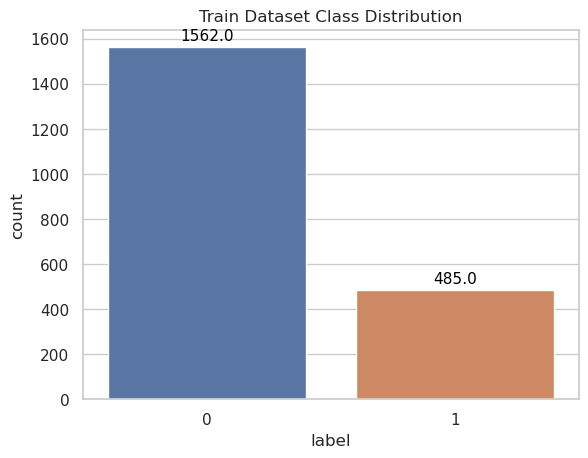

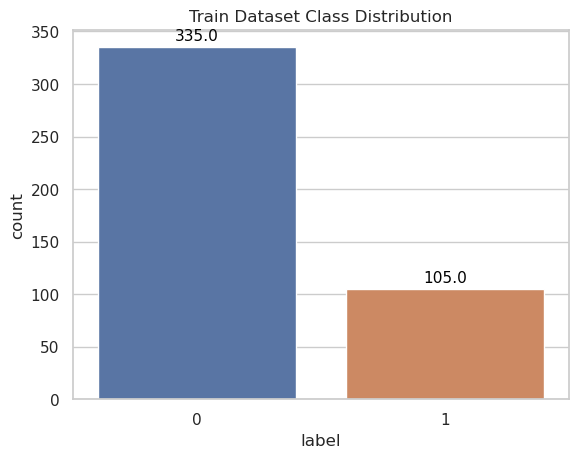

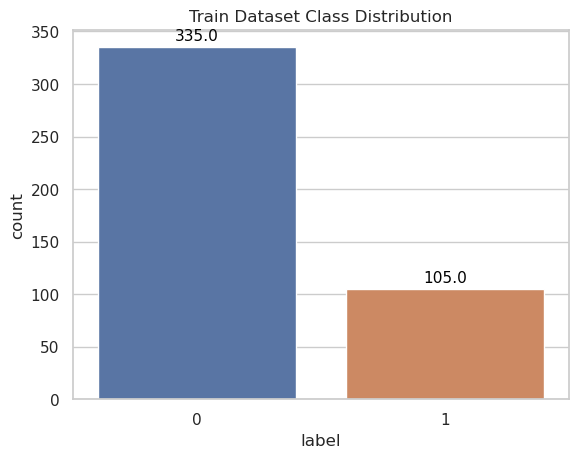

In [149]:
plot_class_distribution(train_set, 'Train Dataset Class Distribution')
plot_class_distribution(test_set, 'Train Dataset Class Distribution')
plot_class_distribution(val_set, 'Train Dataset Class Distribution')

In [150]:
X_train, X_validation, X_test, y_train, y_validation, y_test = vectorize_dataset(train_set, test_set, val_set)

#set the evaluation set for early stop models
eval_set = [(X_validation, y_validation)]

### Random Over-sampling
RandomOverSampler will increase the data samples in the minority class (vishing). It makes the minority class have the same data samples as the majority class (non-vishing).

In [151]:
from imblearn.over_sampling import RandomOverSampler

# define RandomOverSampler strategy
sampling = RandomOverSampler(random_state=42) #sampling_strategy='minority', sampling_strategy parameter is to balance the class to have 1:1 data samples

# Train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 485})
Resampled dataset shape Counter({0: 1562, 1: 1562})
--------------------------------------------------

DecisionTreeClassifier_RandomOverSampler

Training time: 0.392sec
Prediction time (train): 0.008sec
Prediction time (test): 0.002sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9909 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       335
           1       0.97      0.99      0.98       105

    accuracy                           0.99       440
   macro avg       0.98      0.99      0.99       440
weighted avg       0.99      0.99      0.99       440


-- Confusion matrix --
 [[332   3]
 [  1 104]]
True Positives(TP) =  332
True Negatives(TN) =  104
False Positives(FP) =  3
False Negatives(FN) =  1

-- Metrics scores --

Accuracy :0.990909090909091
Precision :0.97196

In [152]:
# Display the results
df_results

,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998
4,DecisionTreeClassifier_RandomOverSampler,0.981132,0.971963,0.990476,0.990760,0.990909,0.392128,0.001256
5,RandomForestClassifier_RandomOverSampler,1.000000,1.000000,1.000000,1.000000,1.000000,0.919142,0.007898
6,XGBClassifier_RandomOverSampler,0.976303,0.971698,0.980952,0.988159,0.988636,0.994270,0.001478
7,LGBMClassifier_RandomOverSampler,0.971698,0.962617,0.980952,0.991414,0.986364,0.625386,0.001265


### SMOTE Over-sampling methods

In [153]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE , ADASYN,SVMSMOTE,KMeansSMOTE,BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

In [154]:
# define SMOTE strategy
sampling = SMOTE(random_state=42) #sampling_strategy='minority', sampling_strategy parameter is to balance the class to have 1:1 data samples

# Train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

# Display the results
df_results

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fdaca45e0>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 485})
Resampled dataset shape Counter({0: 1562, 1: 1562})
--------------------------------------------------

DecisionTreeClassifier_SMOTE

Training time: 1.001sec
Prediction time (train): 0.007sec
Prediction time (test): 0.001sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9909 sec
Prediction time (test): 0.002sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       335
           1       0.98      0.98      0.98       105

    accuracy                           0.99       440
   macro avg       0.99      0.99      0.99       440
weighted avg       0.99      0.99      0.99       440


-- Confusion matrix --
 [[333   2]
 [  2 103]]
True Positives(TP) =  333
True Negatives(TN) =  103
False Positives(FP) =  2
False Negatives(FN) =  2

-- Metrics scores --

Accuracy :0.990909090909091
Precision :0.9809523809523809


,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998
4,DecisionTreeClassifier_RandomOverSampler,0.981132,0.971963,0.990476,0.990760,0.990909,0.392128,0.001256
5,RandomForestClassifier_RandomOverSampler,1.000000,1.000000,1.000000,1.000000,1.000000,0.919142,0.007898
6,XGBClassifier_RandomOverSampler,0.976303,0.971698,0.980952,0.988159,0.988636,0.994270,0.001478
7,LGBMClassifier_RandomOverSampler,0.971698,0.962617,0.980952,0.991414,0.986364,0.625386,0.001265
8,DecisionTreeClassifier_SMOTE,0.980952,0.980952,0.980952,0.987491,0.990909,1.000865,0.000969
9,RandomForestClassifier_SMOTE,1.000000,1.000000,1.000000,1.000000,1.000000,1.073024,0.009086


### Adaptive Synthetic (ADASYN) method

In [155]:
# define ADASYN strategy
sampling = ADASYN(random_state=42) #sampling_strategy='minority', sampling_strategy parameter is to balance the class to have 1:1 data samples

# Train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

# Display the results
df_results

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fdac99b40>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 485})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fdac99f30>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Resampled dataset shape Counter({1: 1563, 0: 1562})
--------------------------------------------------

DecisionTreeClassifier_ADASYN

Training time: 1.016sec
Prediction time (train): 0.006sec
Prediction time (test): 0.002sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9727 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       335
           1       0.97      0.91      0.94       105

    accuracy                           0.97       440
   macro avg       0.97      0.95      0.96       440
weighted avg       0.97      0.97      0.97       440


-- Confusion matrix --
 [[332   3]
 [  9  96]]
True Positives(TP) =  332
True Negatives(TN) =  96
False Positives(FP) =  3
False Negatives(FN) =  9

-- Metrics scores --

Accuracy :0.9727272727272728
Precision :0.9696969696969697
Recall :0.9142857142857143
F1_score :0.9411764705882354
F05_score :0.

,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998
4,DecisionTreeClassifier_RandomOverSampler,0.981132,0.971963,0.990476,0.990760,0.990909,0.392128,0.001256
5,RandomForestClassifier_RandomOverSampler,1.000000,1.000000,1.000000,1.000000,1.000000,0.919142,0.007898
6,XGBClassifier_RandomOverSampler,0.976303,0.971698,0.980952,0.988159,0.988636,0.994270,0.001478
7,LGBMClassifier_RandomOverSampler,0.971698,0.962617,0.980952,0.991414,0.986364,0.625386,0.001265
8,DecisionTreeClassifier_SMOTE,0.980952,0.980952,0.980952,0.987491,0.990909,1.000865,0.000969
9,RandomForestClassifier_SMOTE,1.000000,1.000000,1.000000,1.000000,1.000000,1.073024,0.009086


### KMeansSMOTE method
KMeans clustering before to over-sample using SMOTE.

In [156]:
# define KMeansSMOTE strategy
sampling = KMeansSMOTE(random_state=42) #sampling_strategy='minority', sampling_strategy parameter is to balance the class to have 1:1 data samples

# Train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

# Display the results
df_results

/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fefd2d6c0>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda

-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 485})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fdac99000>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Resampled dataset shape Counter({1: 1563, 0: 1562})
--------------------------------------------------

DecisionTreeClassifier_KMeansSMOTE

Training time: 1.073sec
Prediction time (train): 0.006sec
Prediction time (test): 0.001sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9864 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       335
           1       0.96      0.98      0.97       105

    accuracy                           0.99       440
   macro avg       0.98      0.98      0.98       440
weighted avg       0.99      0.99      0.99       440


-- Confusion matrix --
 [[331   4]
 [  2 103]]
True Positives(TP) =  331
True Negatives(TN) =  103
False Positives(FP) =  4
False Negatives(FN) =  2

-- Metrics scores --

Accuracy :0.9863636363636363
Precision :0.9626168224299065
Recall :0.9809523809523809
F1_score :0.9716981132075471
F05_sco

,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998
4,DecisionTreeClassifier_RandomOverSampler,0.981132,0.971963,0.990476,0.990760,0.990909,0.392128,0.001256
5,RandomForestClassifier_RandomOverSampler,1.000000,1.000000,1.000000,1.000000,1.000000,0.919142,0.007898
6,XGBClassifier_RandomOverSampler,0.976303,0.971698,0.980952,0.988159,0.988636,0.994270,0.001478
7,LGBMClassifier_RandomOverSampler,0.971698,0.962617,0.980952,0.991414,0.986364,0.625386,0.001265
8,DecisionTreeClassifier_SMOTE,0.980952,0.980952,0.980952,0.987491,0.990909,1.000865,0.000969
9,RandomForestClassifier_SMOTE,1.000000,1.000000,1.000000,1.000000,1.000000,1.073024,0.009086


### Borderline SMOTE method

In [157]:
# define BorderlineSMOTE strategy
sampling = BorderlineSMOTE(random_state=42) #sampling_strategy='minority', sampling_strategy parameter is to balance the class to have 1:1 data samples

# Train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

# Display the results
df_results

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fefca4820>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 485})
Resampled dataset shape Counter({0: 1562, 1: 485})
--------------------------------------------------

DecisionTreeClassifier_BorderlineSMOTE

Training time: 1.261sec
Prediction time (train): 0.009sec
Prediction time (test): 0.01sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9864 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       335
           1       0.96      0.98      0.97       105

    accuracy                           0.99       440
   macro avg       0.98      0.98      0.98       440
weighted avg       0.99      0.99      0.99       440


-- Confusion matrix --
 [[331   4]
 [  2 103]]
True Positives(TP) =  331
True Negatives(TN) =  103
False Positives(FP) =  4
False Negatives(FN) =  2

-- Metrics scores --

Accuracy :0.9863636363636363
Precision :0.96261682

,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998
4,DecisionTreeClassifier_RandomOverSampler,0.981132,0.971963,0.990476,0.990760,0.990909,0.392128,0.001256
5,RandomForestClassifier_RandomOverSampler,1.000000,1.000000,1.000000,1.000000,1.000000,0.919142,0.007898
6,XGBClassifier_RandomOverSampler,0.976303,0.971698,0.980952,0.988159,0.988636,0.994270,0.001478
7,LGBMClassifier_RandomOverSampler,0.971698,0.962617,0.980952,0.991414,0.986364,0.625386,0.001265
8,DecisionTreeClassifier_SMOTE,0.980952,0.980952,0.980952,0.987491,0.990909,1.000865,0.000969
9,RandomForestClassifier_SMOTE,1.000000,1.000000,1.000000,1.000000,1.000000,1.073024,0.009086


### SMOTE and cleaning using ENN method

In [158]:
# define SMOTEENN strategy
sampling = SMOTEENN(random_state=42) #sampling_strategy='minority', sampling_strategy parameter is to balance the class to have 1:1 data samples

# Train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

# Display the results
df_results

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fdac8e5f0>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 485})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fec4dbf40>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Resampled dataset shape Counter({1: 1562, 0: 1492})
--------------------------------------------------

DecisionTreeClassifier_SMOTEENN

Training time: 1.336sec
Prediction time (train): 0.006sec
Prediction time (test): 0.001sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9932 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       335
           1       0.98      0.99      0.99       105

    accuracy                           0.99       440
   macro avg       0.99      0.99      0.99       440
weighted avg       0.99      0.99      0.99       440


-- Confusion matrix --
 [[333   2]
 [  1 104]]
True Positives(TP) =  333
True Negatives(TN) =  104
False Positives(FP) =  2
False Negatives(FN) =  1

-- Metrics scores --

Accuracy :0.9931818181818182
Precision :0.9811320754716981
Recall :0.9904761904761905
F1_score :0.9857819905213271
F05_score 

,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998
4,DecisionTreeClassifier_RandomOverSampler,0.981132,0.971963,0.990476,0.990760,0.990909,0.392128,0.001256
5,RandomForestClassifier_RandomOverSampler,1.000000,1.000000,1.000000,1.000000,1.000000,0.919142,0.007898
6,XGBClassifier_RandomOverSampler,0.976303,0.971698,0.980952,0.988159,0.988636,0.994270,0.001478
7,LGBMClassifier_RandomOverSampler,0.971698,0.962617,0.980952,0.991414,0.986364,0.625386,0.001265
8,DecisionTreeClassifier_SMOTE,0.980952,0.980952,0.980952,0.987491,0.990909,1.000865,0.000969
9,RandomForestClassifier_SMOTE,1.000000,1.000000,1.000000,1.000000,1.000000,1.073024,0.009086


### SMOTETomek method 

In [159]:
# define SMOTETomek strategy
sampling = SMOTETomek(random_state=42) #sampling_strategy='minority', sampling_strategy parameter is to balance the class to have 1:1 data samples

# Train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

# Display the results
df_results

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fec4dbf40>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 485})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fdac8fc70>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Resampled dataset shape Counter({0: 1562, 1: 1562})
--------------------------------------------------

DecisionTreeClassifier_SMOTETomek

Training time: 1.564sec
Prediction time (train): 0.031sec
Prediction time (test): 0.002sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9886 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       335
           1       0.97      0.98      0.98       105

    accuracy                           0.99       440
   macro avg       0.98      0.99      0.98       440
weighted avg       0.99      0.99      0.99       440


-- Confusion matrix --
 [[332   3]
 [  2 103]]
True Positives(TP) =  332
True Negatives(TN) =  103
False Positives(FP) =  3
False Negatives(FN) =  2

-- Metrics scores --

Accuracy :0.9886363636363636
Precision :0.9716981132075472
Recall :0.9809523809523809
F1_score :0.976303317535545
F05_score

,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998
4,DecisionTreeClassifier_RandomOverSampler,0.981132,0.971963,0.990476,0.990760,0.990909,0.392128,0.001256
5,RandomForestClassifier_RandomOverSampler,1.000000,1.000000,1.000000,1.000000,1.000000,0.919142,0.007898
6,XGBClassifier_RandomOverSampler,0.976303,0.971698,0.980952,0.988159,0.988636,0.994270,0.001478
7,LGBMClassifier_RandomOverSampler,0.971698,0.962617,0.980952,0.991414,0.986364,0.625386,0.001265
8,DecisionTreeClassifier_SMOTE,0.980952,0.980952,0.980952,0.987491,0.990909,1.000865,0.000969
9,RandomForestClassifier_SMOTE,1.000000,1.000000,1.000000,1.000000,1.000000,1.073024,0.009086


### SVMSMOTE method 

In [160]:
# define SVMSMOTE strategy
sampling = SVMSMOTE(random_state=42) #sampling_strategy='minority', sampling_strategy parameter is to balance the class to have 1:1 data samples

# Train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

# Display the results
df_results

-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 485})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fdac8f760>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Resampled dataset shape Counter({0: 1562, 1: 970})
--------------------------------------------------

DecisionTreeClassifier_SVMSMOTE

Training time: 0.279sec
Prediction time (train): 0.006sec
Prediction time (test): 0.002sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9864 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       335
           1       0.96      0.98      0.97       105

    accuracy                           0.99       440
   macro avg       0.98      0.98      0.98       440
weighted avg       0.99      0.99      0.99       440


-- Confusion matrix --
 [[331   4]
 [  2 103]]
True Positives(TP) =  331
True Negatives(TN) =  103
False Positives(FP) =  4
False Negatives(FN) =  2

-- Metrics scores --

Accuracy :0.9863636363636363
Precision :0.9626168224299065
Recall :0.9809523809523809
F1_score :0.9716981132075471
F05_score :

/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998
4,DecisionTreeClassifier_RandomOverSampler,0.981132,0.971963,0.990476,0.990760,0.990909,0.392128,0.001256
5,RandomForestClassifier_RandomOverSampler,1.000000,1.000000,1.000000,1.000000,1.000000,0.919142,0.007898
6,XGBClassifier_RandomOverSampler,0.976303,0.971698,0.980952,0.988159,0.988636,0.994270,0.001478
7,LGBMClassifier_RandomOverSampler,0.971698,0.962617,0.980952,0.991414,0.986364,0.625386,0.001265
8,DecisionTreeClassifier_SMOTE,0.980952,0.980952,0.980952,0.987491,0.990909,1.000865,0.000969
9,RandomForestClassifier_SMOTE,1.000000,1.000000,1.000000,1.000000,1.000000,1.073024,0.009086


## Training models with Back-translation as text augmentation methods

In [161]:
# import the train_set, test_set, val_set
train_set = pd.read_csv('train_set_clean.csv')
test_set = pd.read_csv('test_set_clean.csv')
val_set = pd.read_csv('val_set_clean.csv')

In [162]:
train_set.head()

,transcript,label,length,transcript_clean,length_transcript_clean,corpus,length_corpus
0,크리스마스 식탁 위에 빠지지 않고 등장하는 존재가 있어. 하얀 생크림 시트 위에 형...,0,3128,크리스마스 식탁 위에 빠지지 않고 등장하는 존재가 있어 하얀 생크림 시트 위에 형형...,3067,크리스마스 식탁 빠지 등장 존재 하얀 생크림 시트 형형색색 화려 올린 크리스마스 케...,1969
1,어~ 혹시 씨는 가족 관계가 어떻게 돼요? 저희 가족은 다섯 명으로 이루어져 있는...,0,6280,어 혹시 씨는 가족 관계가 어떻게 돼요 저희 가족은 다섯 명으로 이루어져 있는데요...,6132,혹시 관계 어떻게 돼요 저희 다섯 으로 동생 엄마 아빠 다섯 에요 저희 엄마 정말 ...,3559
2,음~ 먹거리라는 주제를 가지고 얘기를 해 보고 싶어요. 선생님 요즘에 여름이라서 식...,0,5507,음 먹거리라는 주제를 가지고 얘기를 해 보고 싶어요 선생님 요즘에 여름이라서 식구들...,5320,먹거리 라는 주제 얘기 어요 선생 요즘 여름 라서 식구 입맛 조금 떨어지 밥맛 시기...,3268
3,통화 가능하십니까 어디서 봐요 예 지금 통화 괜찮으시죠 예 혹시 주변에 아는 사람들...,1,897,통화 가능하십니까 어디서 봐요 예 지금 통화 괜찮으시죠 예 혹시 주변에 아는 사람들...,879,통화 십니까 어디 봐요 지금 통화 괜찮 으시 혹시 주변 사람 으세요 감정 으로 출신...,635
4,네이버에 중고나라 사이트 아시죠? 대구지역 있으세요 아시죠? 사이트에서 김재원 일단...,1,416,네이버에 중고나라 사이트 아시죠 대구지역 있으세요 아시죠 사이트에서 김재원 일단은 ...,406,네이버 중고 나라 사이트 대구 지역 으세요 사이트 에서 김재원 일단 그리 국가 물건...,286


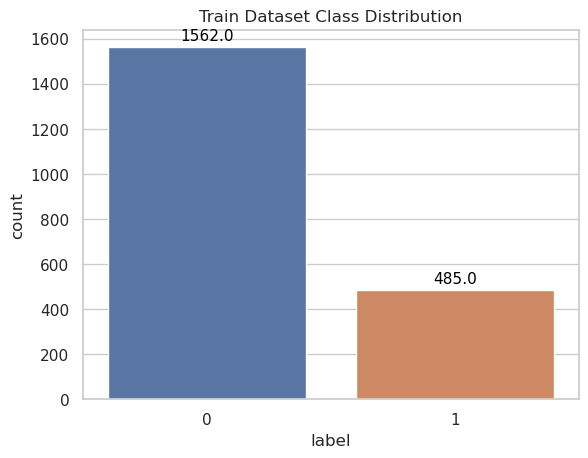

In [163]:
# plot the class distribution of the train_set dataset
plot_class_distribution(train_set, 'Train Dataset Class Distribution')

In [164]:
# import the augmented dataset from back-translation method
train_set_en = pd.read_csv('train_set_en_clean.csv')
train_set_ch = pd.read_csv('train_set_ch_clean.csv')
train_set_ja = pd.read_csv('train_set_ja_clean.csv')

In [165]:
train_set_en

,transcript_en,label,length,transcript_clean_en,length_transcript_clean_en,corpus_en,length_corpus_en
0,시간 있으세요? 어디에서 만나죠? 괜찮아요? 당신 주변에서 제가 감정적인 사람을 본...,1,869,시간 있으세요 어디에서 만나죠 괜찮아요 당신 주변에서 제가 감정적인 사람을 본 적이...,837,시간 으세요 어디 에서 만나 괜찮 아요 당신 주변 에서 감정 사람 나요 당신 당신 ...,592
1,네이버 중고나라 사이트 아시죠? 대구에 한 곳이 있습니다. 알고 있죠? 김재원 씨는...,1,328,네이버 중고나라 사이트 아시죠 대구에 한 곳이 있습니다 알고 있죠 김재원 씨는 현장...,317,네이버 중고 나라 사이트 대구 습니다 김재원 현장 에서 나라 물건 위해 매물 내놓 ...,207
2,"안녕하세요 안녕하세요 아 네, 기간은 5년 7080 bad입니다. 지금도 매일 36...",1,246,안녕하세요 안녕하세요 아 네 기간은 5년 7080 bad입니다 지금도 매일 3632...,227,안녕 세요 안녕 세요 기간 7080 bad 입니다 지금 매일 363255 28 정부...,171
3,"본인이 직접 갚아야 할 경우에는 그 내용이 포함됩니다. 또한 5002,029 Ya...",1,209,본인이 직접 갚아야 할 경우에는 그 내용이 포함됩니다 또한 52029 Ya의 공증...,193,본인 직접 아야 경우 내용 포함 됩니다 또한 52029 Ya 공증 비용 개월 연체 ...,138
4,다른 멤버들은 지금 당장은 안 되는데 언제쯤 가능할까요.,1,32,다른 멤버들은 지금 당장은 안 되는데 언제쯤 가능할까요,31,다른 멤버 지금 당장 언제,14
...,...,...,...,...,...,...,...
480,"안녕하세요.\n네, 안녕하세요\n네.\n(삐) 맞나요?\n네.\n네, 안녕하세요. ...",1,1681,안녕하세요 네 안녕하세요 네 삐 맞나요 네 네 안녕하세요 두 가지 첨단 범죄 수사를...,1603,안녕 세요 안녕 세요 나요 안녕 세요 첨단 범죄 수사 서울 중앙 지검 최태호 수사관...,1127
481,"서울지방경찰청. 네, 저는 서울지방경찰청 김종호입니다.\n저는 가짜 은행 계좌를 가...",1,1422,서울지방경찰청 네 저는 서울지방경찰청 김종호입니다 저는 가짜 은행 계좌를 가지고 있...,1356,서울 지방 경찰청 서울 지방 경찰청 김종호 입니다 계좌 습니다 아니 무슨 통장 불법...,958
482,"안녕하세요.\n네, 손님이세요?\n좋아요.\n안녕하세요 KB캐피탈 고객입니다\n좋아...",1,663,안녕하세요 네 손님이세요 좋아요 안녕하세요 KB캐피탈 고객입니다 좋아요 저희 쪽에서...,634,안녕 세요 세요 아요 안녕 세요 KB 캐피탈 고객 입니다 아요 저희 에서 한도 금액...,440
483,채무 통화 부문에서 대체 대출을 도와드리고 있습니다.. 근데 저희는 부산이 아니에요...,1,2359,채무 통화 부문에서 대체 대출을 도와드리고 있습니다 근데 저희는 부산이 아니에요 우...,2217,채무 통화 부문 에서 대체 대출 도와 드리 습니다 근데 저희 부산 아니 에요 우리 ...,1515


### Training with the English-Korean augmented dataset

In [166]:
# # concatenate train_set and train_set_en dataset and make a new dataset with only train_set['corpus'] and train_set['label'] columns. Add train_set_en['corpus_en'] and train_set_en['label'] columns to the new dataset.
# train_set_en0 = train_set_en[['corpus_en', 'label']]
# train_set_en0.columns = ['corpus', 'label']
# train_set_en0

# # concatenate the augmented train_set_en dataset with the original dataset to create the new train_set dataset for training the models with back-translation method as text augmentation method.  
# train_set00 = pd.concat([train_set, train_set_en], ignore_index=True)
# train_set00

# Make new train_set dataset with only train_set['corpus'] and train_set['label'] columns.
train_set_new = train_set[['corpus', 'label']]
train_set_new.columns = ['corpus', 'label']
train_set_new

,corpus,label
0,크리스마스 식탁 빠지 등장 존재 하얀 생크림 시트 형형색색 화려 올린 크리스마스 케...,0
1,혹시 관계 어떻게 돼요 저희 다섯 으로 동생 엄마 아빠 다섯 에요 저희 엄마 정말 ...,0
2,먹거리 라는 주제 얘기 어요 선생 요즘 여름 라서 식구 입맛 조금 떨어지 밥맛 시기...,0
3,통화 십니까 어디 봐요 지금 통화 괜찮 으시 혹시 주변 사람 으세요 감정 으로 출신...,1
4,네이버 중고 나라 사이트 대구 지역 으세요 사이트 에서 김재원 일단 그리 국가 물건...,1
...,...,...
2042,요새 난민 대해서 우리 예민 부분 잖아요 받아들이 느냐 느냐 대해서 많이 논란 난민...,0
2043,최근 드라마 영화 나요 최근 방영 드라마 하나 잖아요 사이코 사이코 지만 괜찮 드라...,0
2044,요즘 스타 케이크 주문 제작 상품 잖아요 그럼 거기 보통 적혀 잖아요 그래서 디엠 ...,0
2045,중학교 들어가 어떤 생각 다니 중학교 들어가 나요 그냥 중학교 다닐 거리 편할 아서...,0


In [167]:
# Make new train_set_en dataset with only train_set_en['corpus_en'] and train_set_en['label'] columns. Rename the columns to 'corpus_en' to 'corpus'.
train_set_en_new = train_set_en[['corpus_en', 'label']]
train_set_en_new.columns = ['corpus', 'label']
train_set_en_new

,corpus,label
0,시간 으세요 어디 에서 만나 괜찮 아요 당신 주변 에서 감정 사람 나요 당신 당신 ...,1
1,네이버 중고 나라 사이트 대구 습니다 김재원 현장 에서 나라 물건 위해 매물 내놓 ...,1
2,안녕 세요 안녕 세요 기간 7080 bad 입니다 지금 매일 363255 28 정부...,1
3,본인 직접 아야 경우 내용 포함 됩니다 또한 52029 Ya 공증 비용 개월 연체 ...,1
4,다른 멤버 지금 당장 언제,1
...,...,...
480,안녕 세요 안녕 세요 나요 안녕 세요 첨단 범죄 수사 서울 중앙 지검 최태호 수사관...,1
481,서울 지방 경찰청 서울 지방 경찰청 김종호 입니다 계좌 습니다 아니 무슨 통장 불법...,1
482,안녕 세요 세요 아요 안녕 세요 KB 캐피탈 고객 입니다 아요 저희 에서 한도 금액...,1
483,채무 통화 부문 에서 대체 대출 도와 드리 습니다 근데 저희 부산 아니 에요 우리 ...,1


In [168]:
# concatenate the augmented train_set_en dataset with the original dataset to create the new train_set dataset for training the models with back-translation method as text augmentation method.
train_set_EnKo = pd.concat([train_set_new, train_set_en_new], ignore_index=True)
train_set_EnKo

,corpus,label
0,크리스마스 식탁 빠지 등장 존재 하얀 생크림 시트 형형색색 화려 올린 크리스마스 케...,0
1,혹시 관계 어떻게 돼요 저희 다섯 으로 동생 엄마 아빠 다섯 에요 저희 엄마 정말 ...,0
2,먹거리 라는 주제 얘기 어요 선생 요즘 여름 라서 식구 입맛 조금 떨어지 밥맛 시기...,0
3,통화 십니까 어디 봐요 지금 통화 괜찮 으시 혹시 주변 사람 으세요 감정 으로 출신...,1
4,네이버 중고 나라 사이트 대구 지역 으세요 사이트 에서 김재원 일단 그리 국가 물건...,1
...,...,...
2527,안녕 세요 안녕 세요 나요 안녕 세요 첨단 범죄 수사 서울 중앙 지검 최태호 수사관...,1
2528,서울 지방 경찰청 서울 지방 경찰청 김종호 입니다 계좌 습니다 아니 무슨 통장 불법...,1
2529,안녕 세요 세요 아요 안녕 세요 KB 캐피탈 고객 입니다 아요 저희 에서 한도 금액...,1
2530,채무 통화 부문 에서 대체 대출 도와 드리 습니다 근데 저희 부산 아니 에요 우리 ...,1


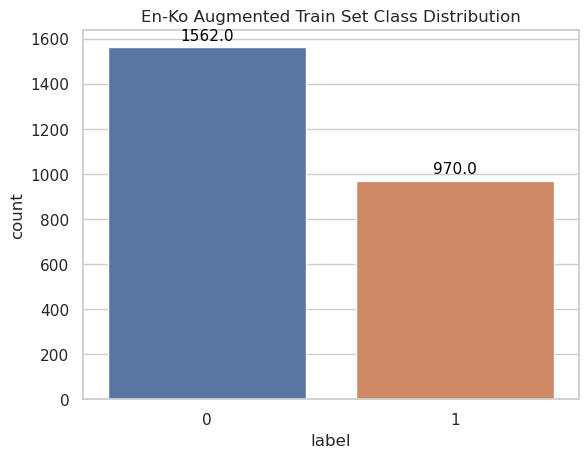

In [169]:
# plot the class distribution of the new train_set dataset 
plot_class_distribution(train_set_EnKo, 'En-Ko Augmented Train Set Class Distribution')

In [170]:
# vectorize the dataset
X_train, X_validation, X_test, y_train, y_validation, y_test = vectorize_dataset(train_set_EnKo, test_set, val_set)

#set the evaluation set for early stop models
eval_set = [(X_validation, y_validation)]

### Training ML models with En-Ko augmented dataset

In [171]:
# define the ML models
models, es_models = define_models()

# Define the Back-translation name En-Ko
bt_name = 'BT-EnKo'

# train the ML models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, bt_name=bt_name)

# Display the results
df_results

-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 970})
--------------------------------------------------

DecisionTreeClassifier_BT-EnKo

Training time: 0.291sec
Prediction time (train): 0.006sec
Prediction time (test): 0.001sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9864 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       335
           1       0.98      0.96      0.97       105

    accuracy                           0.99       440
   macro avg       0.98      0.98      0.98       440
weighted avg       0.99      0.99      0.99       440


-- Confusion matrix --
 [[333   2]
 [  4 101]]
True Positives(TP) =  333
True Negatives(TN) =  101
False Positives(FP) =  2
False Negatives(FN) =  4

-- Metrics scores --

Accuracy :0.9863636363636363
Precision :0.9805825242718447
Recall :0.9619047619047619
F1_score :0.9711538461

,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998
4,DecisionTreeClassifier_RandomOverSampler,0.981132,0.971963,0.990476,0.990760,0.990909,0.392128,0.001256
5,RandomForestClassifier_RandomOverSampler,1.000000,1.000000,1.000000,1.000000,1.000000,0.919142,0.007898
6,XGBClassifier_RandomOverSampler,0.976303,0.971698,0.980952,0.988159,0.988636,0.994270,0.001478
7,LGBMClassifier_RandomOverSampler,0.971698,0.962617,0.980952,0.991414,0.986364,0.625386,0.001265
8,DecisionTreeClassifier_SMOTE,0.980952,0.980952,0.980952,0.987491,0.990909,1.000865,0.000969
9,RandomForestClassifier_SMOTE,1.000000,1.000000,1.000000,1.000000,1.000000,1.073024,0.009086


### Training with the Chinese-Korean augmented dataset

In [172]:
# # concatenate train_set and train_set_ch dataset and make a new dataset with only train_set['corpus'] and train_set['label'] columns. Add train_set_ch['corpus_ch'] and train_set_ch['label'] columns to the new dataset.
# train_set_ch0 = train_set_ch[['corpus_ch', 'label']]
# train_set_ch0.columns = ['corpus', 'label']
# train_set_ch0
# 
# # concatenate the augmented train_set_ch dataset with the original dataset to create the new train_set dataset for training the models with back-translation method as text augmentation method.
# train_set0 = pd.concat([train_set, train_set_ch0], ignore_index=True)
# train_set0
# 
# # Make new train_set dataset with only train_set['corpus'] and train_set['label'] columns.
# train_set_new = train_set[['corpus', 'label']]
# train_set_new.columns = ['corpus', 'label']
# train_set_new

# Make new train_set_ch dataset with only train_set_ch['corpus_ch'] and train_set_ch['label'] columns. Rename the columns to 'corpus_ch' to 'corpus'.
train_set_ch_new = train_set_ch[['corpus_ch', 'label']]
train_set_ch_new.columns = ['corpus', 'label']
train_set_ch_new

,corpus,label
0,통화 어디 만날까요 지금 통화 괜찮 으시 혹시 주변 사람 나요 감정 출신 인데 자막...,1
1,네이버 중고 나라 사이트 대구 지역 나요 홈페이지 에서 김재원 먼저 나라 물건 판다...,1
2,아예 만기 7080 으로 해서 지금 하루 36 3255 28 정부 지원금 으로 국민...,1
3,고객 상담 김정훈 대리 입니다 고객 소득 담보 대출 진행 때문 대출계 약서 특약 사...,1
4,말씀 세요 나요 취소 시간 알려 어요 해지 시간 10 입니다 다시 말씀 어요 13 ...,1
...,...,...
480,여보세요 여보세요 안녕 세요 예요 아요 예요 안녕 세요 지금 서울 중앙지 첨단 범죄...,1
481,서울 지방 경찰청 그렇게 서울 지방 경찰청 김종호 대포통장 나요 대포통장 결제 계좌...,1
482,여보세요 고객 고객 안녕 세요 kb 캐피탈 고객 입니다 지금 전화 드린 다름 아니 ...,1
483,채무 통화 으로 대체 대출 드리 습니다 그런데 저희 부산 아니 저희 서울 광교 지점...,1


In [173]:
# concatenate the augmented train_set_ch dataset with the original dataset to create the new train_set dataset for training the models with back-translation method as text augmentation method.
train_set_ChKo = pd.concat([train_set_new, train_set_ch_new], ignore_index=True)
train_set_ChKo

,corpus,label
0,크리스마스 식탁 빠지 등장 존재 하얀 생크림 시트 형형색색 화려 올린 크리스마스 케...,0
1,혹시 관계 어떻게 돼요 저희 다섯 으로 동생 엄마 아빠 다섯 에요 저희 엄마 정말 ...,0
2,먹거리 라는 주제 얘기 어요 선생 요즘 여름 라서 식구 입맛 조금 떨어지 밥맛 시기...,0
3,통화 십니까 어디 봐요 지금 통화 괜찮 으시 혹시 주변 사람 으세요 감정 으로 출신...,1
4,네이버 중고 나라 사이트 대구 지역 으세요 사이트 에서 김재원 일단 그리 국가 물건...,1
...,...,...
2527,여보세요 여보세요 안녕 세요 예요 아요 예요 안녕 세요 지금 서울 중앙지 첨단 범죄...,1
2528,서울 지방 경찰청 그렇게 서울 지방 경찰청 김종호 대포통장 나요 대포통장 결제 계좌...,1
2529,여보세요 고객 고객 안녕 세요 kb 캐피탈 고객 입니다 지금 전화 드린 다름 아니 ...,1
2530,채무 통화 으로 대체 대출 드리 습니다 그런데 저희 부산 아니 저희 서울 광교 지점...,1


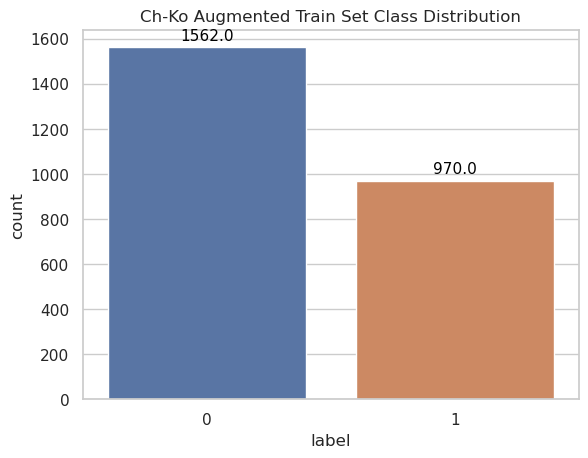

In [174]:

# plot the class distribution of the new train_set dataset
plot_class_distribution(train_set_ChKo, 'Ch-Ko Augmented Train Set Class Distribution')

In [175]:
# vectorize the dataset
X_train, X_validation, X_test, y_train, y_validation, y_test = vectorize_dataset(train_set_ChKo, test_set, val_set)

#set the evaluation set for early stop models
eval_set = [(X_validation, y_validation)]

### Training ML models with Ch-Ko augmented dataset

In [176]:
# define the ML models
models, es_models = define_models()

# Define the Back-translation name En-Ko
bt_name = 'BT-ChKo'

# train the ML models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, bt_name=bt_name)

# Display the results
df_results

-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 970})
--------------------------------------------------

DecisionTreeClassifier_BT-ChKo

Training time: 0.293sec
Prediction time (train): 0.006sec
Prediction time (test): 0.002sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9773 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       335
           1       0.95      0.95      0.95       105

    accuracy                           0.98       440
   macro avg       0.97      0.97      0.97       440
weighted avg       0.98      0.98      0.98       440


-- Confusion matrix --
 [[330   5]
 [  5 100]]
True Positives(TP) =  330
True Negatives(TN) =  100
False Positives(FP) =  5
False Negatives(FN) =  5

-- Metrics scores --

Accuracy :0.9772727272727273
Precision :0.9523809523809523
Recall :0.9523809523809523
F1_score :0.9523809523

/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998
4,DecisionTreeClassifier_RandomOverSampler,0.981132,0.971963,0.990476,0.990760,0.990909,0.392128,0.001256
5,RandomForestClassifier_RandomOverSampler,1.000000,1.000000,1.000000,1.000000,1.000000,0.919142,0.007898
6,XGBClassifier_RandomOverSampler,0.976303,0.971698,0.980952,0.988159,0.988636,0.994270,0.001478
7,LGBMClassifier_RandomOverSampler,0.971698,0.962617,0.980952,0.991414,0.986364,0.625386,0.001265
8,DecisionTreeClassifier_SMOTE,0.980952,0.980952,0.980952,0.987491,0.990909,1.000865,0.000969
9,RandomForestClassifier_SMOTE,1.000000,1.000000,1.000000,1.000000,1.000000,1.073024,0.009086


### Training with the Japanese-Korean augmented dataset

In [177]:
# Make new train_set_ja dataset with only train_set_ja['corpus_ja'] and train_set_ja['label'] columns. Rename the columns to 'corpus_ja' to 'corpus'.
train_set_ja_new = train_set_ja[['corpus_ja', 'label']]
train_set_ja_new.columns = ['corpus', 'label']
train_set_ja_new

,corpus,label
0,통화 한가요 어디 만나 지금 통화 괜찮 주변 지인 나요 감정상 출신 인데 자막 들어...,1
1,네이버 중고 나라 사이트 대구 지역 어요 사이트 에서 김재원 일단 그렇 물건 다고 ...,1
2,여보세요 여보세요 또는 기간 7080 나쁘 지금 매일 36 3255 28 정부 지원...,1
3,고객 담사 김정훈 대리 입니다 고객 소득 담보 대출 때문 관련 해서 대출 계약서 특...,1
4,말씀 세요 어요 해지 시간 알려 어요 해지 시간 일시 으로 입니다 13 다시 말씀 ...,1
...,...,...
480,여보세요 여보세요 나요 안녕 세요 지금 서울 중앙지 첨단 범죄 수사 최태호 수사관 ...,1
481,서울 지방 경찰청 그렇게 세요 서울 지방 경찰청 김정호 입니다 대포통장 나요 아닙니...,1
482,여보세요 고객 으신 안녕 세요 저희 kb 캐피탈 입니다 고객 지금 전화 드린 다름 ...,1
483,채무 통화 으로 지금 대안 대출 진행 습니다 근데 저희 부산 아니 라요 서울 광교 ...,1


In [178]:
# concatenate the augmented train_set_ja dataset with the original dataset to create the new train_set dataset for training the models with back-translation method as text augmentation method.
train_set_JaKo = pd.concat([train_set_new, train_set_ja_new], ignore_index=True)
train_set_JaKo

,corpus,label
0,크리스마스 식탁 빠지 등장 존재 하얀 생크림 시트 형형색색 화려 올린 크리스마스 케...,0
1,혹시 관계 어떻게 돼요 저희 다섯 으로 동생 엄마 아빠 다섯 에요 저희 엄마 정말 ...,0
2,먹거리 라는 주제 얘기 어요 선생 요즘 여름 라서 식구 입맛 조금 떨어지 밥맛 시기...,0
3,통화 십니까 어디 봐요 지금 통화 괜찮 으시 혹시 주변 사람 으세요 감정 으로 출신...,1
4,네이버 중고 나라 사이트 대구 지역 으세요 사이트 에서 김재원 일단 그리 국가 물건...,1
...,...,...
2527,여보세요 여보세요 나요 안녕 세요 지금 서울 중앙지 첨단 범죄 수사 최태호 수사관 ...,1
2528,서울 지방 경찰청 그렇게 세요 서울 지방 경찰청 김정호 입니다 대포통장 나요 아닙니...,1
2529,여보세요 고객 으신 안녕 세요 저희 kb 캐피탈 입니다 고객 지금 전화 드린 다름 ...,1
2530,채무 통화 으로 지금 대안 대출 진행 습니다 근데 저희 부산 아니 라요 서울 광교 ...,1


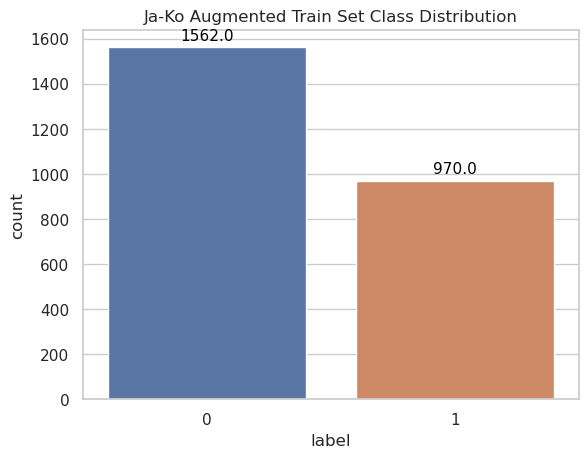

In [179]:
# plot the class distribution of the new train_set dataset
plot_class_distribution(train_set_JaKo, 'Ja-Ko Augmented Train Set Class Distribution')

In [180]:
# vectorize the dataset
X_train, X_validation, X_test, y_train, y_validation, y_test = vectorize_dataset(train_set_JaKo, test_set, val_set)

### Training ML models with Ja-Ko augmented dataset

In [181]:
# define the ML models
models, es_models = define_models()

# Define the Back-translation name En-Ko
bt_name = 'BT-JaKo'

# train the ML models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, bt_name=bt_name)

# Display the results
df_results

-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 970})
--------------------------------------------------

DecisionTreeClassifier_BT-JaKo

Training time: 0.336sec
Prediction time (train): 0.005sec
Prediction time (test): 0.001sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9864 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       335
           1       0.97      0.97      0.97       105

    accuracy                           0.99       440
   macro avg       0.98      0.98      0.98       440
weighted avg       0.99      0.99      0.99       440


-- Confusion matrix --
 [[332   3]
 [  3 102]]
True Positives(TP) =  332
True Negatives(TN) =  102
False Positives(FP) =  3
False Negatives(FN) =  3

-- Metrics scores --

Accuracy :0.9863636363636363
Precision :0.9714285714285714
Recall :0.9714285714285714
F1_score :0.9714285714

/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998
4,DecisionTreeClassifier_RandomOverSampler,0.981132,0.971963,0.990476,0.990760,0.990909,0.392128,0.001256
5,RandomForestClassifier_RandomOverSampler,1.000000,1.000000,1.000000,1.000000,1.000000,0.919142,0.007898
6,XGBClassifier_RandomOverSampler,0.976303,0.971698,0.980952,0.988159,0.988636,0.994270,0.001478
7,LGBMClassifier_RandomOverSampler,0.971698,0.962617,0.980952,0.991414,0.986364,0.625386,0.001265
8,DecisionTreeClassifier_SMOTE,0.980952,0.980952,0.980952,0.987491,0.990909,1.000865,0.000969
9,RandomForestClassifier_SMOTE,1.000000,1.000000,1.000000,1.000000,1.000000,1.073024,0.009086


## Training models with combination of all back-translated datasets (EnKo, ChKo, JaKo)

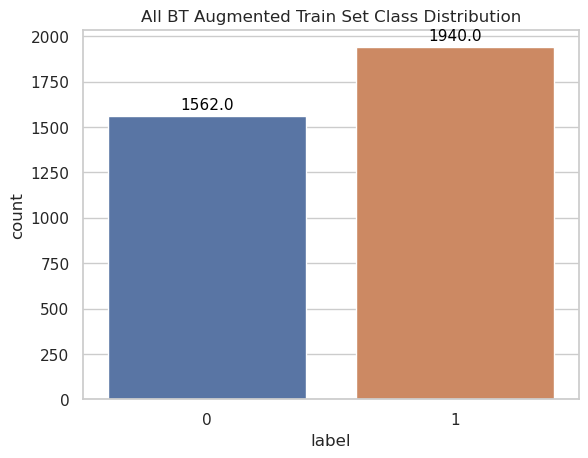

In [182]:
# concatenate the augmented train_set_new, train_set_en_new, train_set_ch_new, train_set_ja_new dataset to a new dataset

train_set_all = pd.concat([train_set_new, train_set_en_new, train_set_ch_new, train_set_ja_new], ignore_index=True)
train_set_all

# plot the class distribution of the new train_set dataset
plot_class_distribution(train_set_all, 'All BT Augmented Train Set Class Distribution')

In [183]:
# vectorize the dataset
X_train, X_validation, X_test, y_train, y_validation, y_test = vectorize_dataset(train_set_all, test_set, val_set)

#set the evaluation set for early stop models
eval_set = [(X_validation, y_validation)]

### Training ML model with Original+EnKo+ChKo+JaKo dataset 

In [184]:
# define the ML models
models, es_models = define_models()

# Define the Back-translation name
bt_name = 'BT-All'

# train the ML models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, bt_name=bt_name)

# Display the results
df_results

-- Dataset shape --
Original dataset shape
Counter({1: 1940, 0: 1562})
--------------------------------------------------

DecisionTreeClassifier_BT-All

Training time: 0.673sec
Prediction time (train): 0.007sec
Prediction time (test): 0.001sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.9977 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       335
           1       1.00      0.99      1.00       105

    accuracy                           1.00       440
   macro avg       1.00      1.00      1.00       440
weighted avg       1.00      1.00      1.00       440


-- Confusion matrix --
 [[335   0]
 [  1 104]]
True Positives(TP) =  335
True Negatives(TN) =  104
False Positives(FP) =  0
False Negatives(FN) =  1

-- Metrics scores --

Accuracy :0.9977272727272727
Precision :1.0
Recall :0.9904761904761905
F1_score :0.9952153110047847
F05_scor

,Model,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
0,DecisionTreeClassifier_,0.957346,0.952830,0.961905,0.973490,0.979545,0.929406,0.001003
1,RandomForestClassifier_,1.000000,1.000000,1.000000,1.000000,1.000000,0.797958,0.009684
2,XGBClassifier_,0.879581,0.976744,0.800000,0.981578,0.947727,0.751058,0.001747
3,LGBMClassifier_,0.918367,0.989011,0.857143,0.996105,0.963636,0.717216,0.000998
4,DecisionTreeClassifier_RandomOverSampler,0.981132,0.971963,0.990476,0.990760,0.990909,0.392128,0.001256
5,RandomForestClassifier_RandomOverSampler,1.000000,1.000000,1.000000,1.000000,1.000000,0.919142,0.007898
6,XGBClassifier_RandomOverSampler,0.976303,0.971698,0.980952,0.988159,0.988636,0.994270,0.001478
7,LGBMClassifier_RandomOverSampler,0.971698,0.962617,0.980952,0.991414,0.986364,0.625386,0.001265
8,DecisionTreeClassifier_SMOTE,0.980952,0.980952,0.980952,0.987491,0.990909,1.000865,0.000969
9,RandomForestClassifier_SMOTE,1.000000,1.000000,1.000000,1.000000,1.000000,1.073024,0.009086


In [185]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

# use nested cross validation to evaluate the model with the best hyperparameters on the test set 
# define the model
model = XGBClassifier(
    early_stopping_rounds=10,
    verbosity=2,
    # n_estimators=2000,
    # tree_method='hist',
    # subsample=0.67,
    # colsample_level=0.06,
    # n_jobs=6,
    # random_state=1234
)

# define the evaluation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

# define the search
grid = dict()
grid['n_estimators'] = [100, 500, 1000]
grid['max_depth'] = [10, 20, 30]
grid['learning_rate'] = [0.001, 0.01, 0.1]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['colsample_bytree'] = [0.5, 0.7, 1.0]

# define the search using nested cross-validation
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv_inner, refit=True)

# configure the cross-validation procedure
cv_outer = KFold(n_splits=3, shuffle=True, random_state=1)

In [186]:
# execute the nested cross-validation
scores = cross_val_score(search, X_train, y_train, scoring='accuracy', cv=cv_outer, n_jobs=-1)

ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 874, in fit
    self._run_search(evaluate_candidates)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 851, in evaluate_candidates
    _warn_or_raise_about_fit_failures(out, self.error_score)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 367, in _warn_or_raise_about_fit_failures
    raise ValueError(all_fits_failed_message)
ValueError: 
All the 729 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
729 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/xgboost/training.py", line 182, in train
    if cb_container.after_iteration(bst, i, dtrain, evals):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/xgboost/callback.py", line 241, in after_iteration
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/xgboost/callback.py", line 241, in <genexpr>
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/xgboost/callback.py", line 426, in after_iteration
    raise ValueError(msg)
ValueError: Must have at least 1 validation dataset for early stopping.



In [ ]:
from numpy import mean, std

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
# summarize the best hyperparameter combination
print('Best Hyperparameters: %s' % search.best_params_)


In [ ]:
# report the best configuration
print('Config: %s' % search.best_params_)

In [ ]:
# report all configurations
means = search.cv_results_['mean_test_score']
params = search.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

In [ ]:
#fit the model
search.fit(X_train, y_train)

In [ ]:
# evaluate the model
yhat = search.predict(X_test)

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
# use nested cross validation to evaluate the model with the best hyperparameters on the test set
# define the model
model = LGBMClassifier(
    early_stopping_rounds=10,
    verbosity=2,
    # boost_from_average=False
    # num_leaves=64,
    # n_estimators=2000,
    # feature_fraction=0.06,
    # bagging_fraction=0.67,
    # bagging_freq=1,
    # n_jobs=6,
    # random_state=1234
)
    


## Training model with feature selection

In [ ]:
# import the train_set, test_set, val_set
train_set = pd.read_csv('train_set_clean.csv')
test_set = pd.read_csv('test_set_clean.csv')
val_set = pd.read_csv('val_set_clean.csv')

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif


# define the feature selection method
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [ ]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

In [ ]:
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

In [ ]:
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [ ]:
# define the model
model = XGBClassifier(
    # early_stopping_rounds=10,
    verbosity=2,
    # n_estimators=2000,
    # tree_method='hist',
    # subsample=0.67,
    # colsample_level=0.06,
    # n_jobs=6,
    # random_state=1234
)

In [ ]:
# fit the model
model.fit(X_train_fs, y_train)

In [ ]:
# evaluate the model
yhat = model.predict(X_test_fs)

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
# define the model
model = LGBMClassifier(
    # early_stopping_rounds=10,
    verbosity=2,
    # boost_from_average=False
    # num_leaves=64,
    # n_estimators=2000,
    # feature_fraction=0.06,
    # bagging_fraction=0.67,
    # bagging_freq=1,
    # n_jobs=6,
    # random_state=1234
)

In [ ]:
# fit the model
model.fit(X_train_fs, y_train)

In [ ]:
# evaluate the model
yhat = model.predict(X_test_fs)

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))    

#